# **Library Book Recommendation System**
---
Authors: [Monicah Iwagit](https://github.com/Okodoimonicah), [Bradley Azegele](https://github.com/Azegele), [Emmanuel Kipkorir](), [Belinda Nyamai](), [Femi Kamau](https://github.com/ctrl-Karugu), and [Dennis Kimiri]()

## 1. Business Understanding

### 1.1 Problem Statement
>The tremendous growth and usage of information has led to information overloading where users find it difficult to locate the right information at a specified time. Although there are previous studies conducted on library recommender systems, the datasets used were small compared to the dataset we intend to use hence minimal area coverage. Recommending the right library books is a challenge due to the variety of genres available and the huge collection of books provided. A user finds it difficult to select the most appropriate book that will suit their academic needs, this process consumes a lot of time that the user would have used to sharpen on their desired skills. Additionally, many books in the library are rarely utilized which results in a waste of library resources. Having a personalized recommendation system seeks to predict the preference based on the user’s interest, behavior and information. The application of recommender systems in a library set up solves the problem of difficulty in choosing books and improves utilization rate of library resources. 

## 2. Data Understanding
> The goal of the Data Understanding phase is to provide a solid foundation for the subsequent steps, including data preparation, exploratory data analysis, model development, and evaluation.

#### Load Libraries

In [172]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Cleaning
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Miscellaneous
import warnings

# Models
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 20)

### 2.1 Collect Initial Data
> The aim of this section is to acquire the necessary data and load it into the notebook.

The data used in this project was extracted from 2 different sources:
>   1. The first was source was from Cai-Nicolas Ziegler in a 4-week crawl (August-September [2004]) in the University of Freiburg, Germany. This can be found [here](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The data obtained are 3 datasets with information on [users](./data/BX-Users.csv), [ratings](./data/BX-Book-Ratings.csv) and [books](./data/BX-Books.csv) from a library.
>
>   2. The second set of data was sourced from the [Google Books API](https://developers.google.com/books). This data was obtained by using ISBNs in the books dataset from the first source. The python script used to extract the data can be found [here](./make_dataset.py). This data was then stored in csv format and can be found [here](./data/api-data.csv).

#### Load Data

In [173]:
# (Source 1)
ratings = pd.read_csv(
    "data/BX-Book-Ratings.csv", sep=";", error_bad_lines=False, encoding="iso-8859-1"
)
books = pd.read_csv(
    "data/BX-Books.csv", sep=";", error_bad_lines=False, encoding="iso-8859-1"
)
users = pd.read_csv(
    "data/BX-Users.csv", sep=";", error_bad_lines=False, encoding="iso-8859-1"
)

# (Source 2)
books_extra = pd.read_csv("data/api-books.csv", dtype={"join_isbn_10": str})

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### 2.2 Describe Data
> The goal of this section is to examine the data and document its surface properties.

In [174]:
# Define class to describe the data
class DescribeData:
    """This class is used to describe the data in a DataFrame."""

    def __init__(self, df) -> None:

        # Get the DataFrame
        self.df = df

        # Get the datatypes of the columns in the DataFrame
        self.datatypes = df.dtypes

        # Get the shape of the DataFrame
        self.shape = f"The shape of the DataFrame is {df.shape}\n\nRecords: {df.shape[0]}\nColumns: {df.shape[1]}"

        # Get the number of missing values in each column
        self.missing = f"There are a total of {df.isnull().sum().values.sum()} missing values in the DataFrame.\n\n{df.isnull().sum()}"

        # Get the number of duplicate rows
        self.duplicates = (
            f"There are {df.duplicated().sum()} duplicated records in the DataFrame."
        )

#### 2.2.1 `ratings`

In [175]:
# Create an instance of the 'DescribeData' class for the 'ratings' DataFrame
rt = DescribeData(ratings)


In [176]:
# Preview the 'ratings' DataFrame
rt.df.head()


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [177]:
# Inspect the information about the DataFrame
rt.df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [178]:
# Inspect the shape of the DataFrame
print(rt.shape)


The shape of the DataFrame is (1149780, 3)

Records: 1149780
Columns: 3


In [179]:
# Inspect the datatypes of the columns in the DataFrame
print(rt.datatypes)


User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object


In [180]:
# Inspect the summary statistics of the DataFrame
rt.df.describe()


,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [181]:
# Inspect the number of missing values in each column
print(rt.missing)

There are a total of 0 missing values in the DataFrame.

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [182]:
# Inspect the duplicates in the DataFrame
print(rt.duplicates)

There are 0 duplicated records in the DataFrame.


[**Ratings Dataset**](./data/BX-Book-Ratings.csv)

>* Spans **3** columns and **1,149,780** rows.

>* Contains **2** unique datatypes: 
>    * **int64**
>    * **object**

>* No missing values

>* No duplicates

#### 2.2.2 `books` 

In [183]:
# Instantiate the 'DescribeData' class for the 'books' DataFrame
bk = DescribeData(books)


In [184]:
# Preview the 'books' DataFrame
bk.df.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,http://images.am...,http://images.am...
1,0002005018,Clara Callan,Richard Bruce Wr...,2001,HarperFlamingo C...,http://images.am...,http://images.am...,http://images.am...
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,http://images.am...,http://images.am...
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,http://images.am...,http://images.am...
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,http://images.am...,http://images.am...


In [185]:
# Inspect the information about the DataFrame
bk.df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [186]:
# Inspect the shape of the DataFrame
print(bk.shape)


The shape of the DataFrame is (271360, 8)

Records: 271360
Columns: 8


In [187]:
# Inspect the datatypes of the columns in the DataFrame
print(bk.datatypes)


ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object


In [188]:
# Inspect the missing values in the DataFrame
print(bk.missing)


There are a total of 6 missing values in the DataFrame.

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [189]:
# Inspect the duplicates in the DataFrame
print(bk.duplicates)


There are 0 duplicated records in the DataFrame.


[**Books Dataset**](./data/BX-Books.csv)

>* Spans **8** columns and **271,360** rows.

>* Contains 1 unique datatype: 
>   * **object**

>* **6** missing values:
>   * Book-Author: **1** 
>   * Publisher: **2**
>   * Image-URL-L: **3**

>* No duplicates

#### 2.2.3 `users` 

In [190]:
# Instantiate the 'DescribeData' class for the 'users' DataFrame
ur = DescribeData(users)


In [191]:
# Preview the 'users' DataFrame
ur.df.head()


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, califo...",18.0
2,3,"moscow, yukon te...",NaN
3,4,"porto, v.n.gaia,...",17.0
4,5,"farnborough, han...",NaN


In [192]:
# Inspect the information about the DataFrame
ur.df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [193]:
# Inspect the shape of the DataFrame
print(ur.shape)


The shape of the DataFrame is (278858, 3)

Records: 278858
Columns: 3


In [194]:
# Inspect the datatypes of the columns in the DataFrame
print(ur.datatypes)


User-ID       int64
Location     object
Age         float64
dtype: object


In [195]:
# Inspect the summary statistics of the DataFrame
ur.df.describe()


,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [196]:
# Inspect the missing values in the DataFrame
print(ur.missing)


There are a total of 110762 missing values in the DataFrame.

User-ID          0
Location         0
Age         110762
dtype: int64


In [197]:
# Inspect the duplicates in the DataFrame
print(ur.duplicates)


There are 0 duplicated records in the DataFrame.


[**Users Dataset**](./data/BX-Users.csv)

>* Spans **3** columns and **278,858** rows.

>* Contains **3** unique datatypes:
>   * **int64**
>   * **float64**
>   * **object**

>* **110,762** missing values:
>   * Age: **110,762**

>* No duplicates

#### 2.2.4 `books_extra`

In [198]:
# Instantiate the 'DescribeData' class for the 'books_extra' DataFrame
bk_extra = DescribeData(books_extra)


In [199]:
# Preview the 'books_extra' DataFrame
bk_extra.df.head()


,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,['Mark P. O. Mor...,2003,Provides an intr...,0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the fi...",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kola...,1999,Describes the gr...,9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,A look at the in...,0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [200]:
# Inspect the information about the DataFrame
bk_extra.df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271044 entries, 0 to 271043
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   authors          210684 non-null  object 
 1   published_date   212589 non-null  object 
 2   description      180298 non-null  object 
 3   isbn_10          212653 non-null  object 
 4   isbn_13          179739 non-null  object 
 5   page_count       211385 non-null  float64
 6   categories       199011 non-null  object 
 7   maturity_rating  212741 non-null  object 
 8   language         212741 non-null  object 
 9   join_isbn_10     271044 non-null  object 
dtypes: float64(1), object(9)
memory usage: 20.7+ MB


In [201]:
# Inspect the shape of the DataFrame
print(bk_extra.shape)


The shape of the DataFrame is (271044, 10)

Records: 271044
Columns: 10


In [202]:
# Inspect the datatypes of the columns in the DataFrame
print(bk_extra.datatypes)


authors             object
published_date      object
description         object
isbn_10             object
isbn_13             object
page_count         float64
categories          object
maturity_rating     object
language            object
join_isbn_10        object
dtype: object


In [203]:
# Inspect the summary statistics of the DataFrame
bk_extra.df.describe()


,page_count
count,211385.000000
mean,279.534995
std,179.001719
min,0.000000
25%,176.000000
50%,260.000000
75%,356.000000
max,3596.000000


In [204]:
# Inspect the missing values in the DataFrame
print(bk_extra.missing)


There are a total of 607555 missing values in the DataFrame.

authors            60360
published_date     58455
description        90746
isbn_10            58391
isbn_13            91305
page_count         59659
categories         72033
maturity_rating    58303
language           58303
join_isbn_10           0
dtype: int64


In [205]:
# Inspect the duplicates in the DataFrame
print(bk_extra.duplicates)


There are 0 duplicated records in the DataFrame.


[**Books (Extra) Dataset**](./data/api-books.csv)

>* Spans **10** columns and **271,044** rows.

>* Contains **2** unique datatypes:
>   * **float64**
>   * **object**

>* **607,555** missing values:
>   * authors: **60,360**
>   * published_date: **58,455**
>   * description: **90,746**
>   * isbn_10: **58,391**
>   * isbn_13: **91,305**
>   * page_count: **59,659**
>   * categories: **72,033**
>   * maturity_rating: **58,303**
>   * language: **58,303**

>* No duplicates

## 3. Data Preparation
> The goal of the Data Preparation phase is to prepare the final data set(s) for modeling. It has five tasks:

>   * Select Data
>   * Clean Data
>   * Construct Data
>   * Integrate Data
>   * Format Data

### 3.1 `books`

In [206]:
# checking the shape of the books dataset before dealing with erroneous ISBN values
books.shape


(271360, 8)

To evaluate further if there are any duplicates in the isbn column, we now convert all alphabets contained into uppercase and remove white spaces case for consistency.

In [207]:
# converting the books ISBN numbers to upper string and removing any white spaces
books["ISBN"] = books["ISBN"].str.upper().str.replace(" ", "")


In [208]:
# checking for duplicates
books["ISBN"].duplicated().sum()


314

> [Books dataset](http://localhost:8888/notebooks/data/BX-Books.csv)

   * 271360 books
   * 314 duplicates
   

We also notice that a number of the isbn's have erroneous values that need to be dealt with. Typically an isbn should be of length 10. Therefore, for isbn less than 10 we pad it with 0's at the beginning, isbn greater than 10 we strip the extra numbers, and use a regular expression to try to extract the first 10 characters of the ISBN that consist only of digits and 'X' or 'x'   

In [209]:
# function to correct the ISBN that are not in correct format


def correct_isbn(isbn):
    # Convert the ISBN to a string, in case it was passed as an integer or float
    isbn = str(isbn)
    # String to use for padding the ISBN with zeros
    fill = "0"
    # Check if the ISBN is less than 10 characters
    if len(isbn) < 10:
        # Calculate the number of characters missing from the ISBN
        missing = 10 - len(isbn)
        # Pad the beginning of the ISBN with the fill string
        new_isbn = (fill * missing) + isbn
        # Return the padded ISBN
        return new_isbn
    # Check if the ISBN is greater than 10 characters
    elif len(isbn) > 10:
        # Try to use a regular expression to extract the first 10 characters of the ISBN
        # that consist only of digits and 'X' or 'x'
        try:
            # Regular expression pattern to match 10 digits and 'X' or 'x'
            pattern = r"^[0-9Xx]{10}"
            # Search for a match in the ISBN
            result = re.search(pattern, isbn)
            # Extract the first 10 characters that match the pattern
            new_isbn = result.group(0)
            # Return the extracted ISBN
            return new_isbn
        # If the regular expression fails, catch the exception and return the original ISBN
        except:
            # Return the original ISBN
            return isbn

    # If the ISBN is already 10 characters, return it as is
    return isbn


In [210]:
# apply the function to the books ISBN column
books["ISBN"] = books["ISBN"].apply(correct_isbn)


Comparing the books dataset and extra_books obtained from google books API, we notice that our books dataset has extra 2 books. 
To correct this, write a function that will only pick the first 10 digits of the isbn

In [211]:
# Create a list of ISBNs from 'join_isbn_10' column
api_isbns = books_extra["join_isbn_10"].to_list()


In [212]:
# Select rows from the 'books' DataFrame where the 'ISBN' column value is not in the 'api_isbns' list
selected_rows = books.query("ISBN not in @api_isbns")
selected_rows


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [213]:
# create a function to obtain the isbn
def extract_isbn(isbn):
    # Use a regular expression to extract the first 10 digits of the ISBN
    pattern = r"^[0-9]{10}"
    result = re.search(pattern, isbn)
    # Return the extracted ISBN, or the original ISBN if no match is found
    return result.group(0) if result else isbn


In [214]:
# apply the function to the books ISBN
books["ISBN"] = books["ISBN"].apply(extract_isbn)


In [215]:
# dropping duplicates
books.drop_duplicates(subset=["ISBN"], inplace=True)


In [216]:
# checking the shape of the new dataset after dealing with duplicates
books.shape


(271044, 8)

In [217]:
# shape of books sourced from google books API
books_extra.shape


(271044, 10)

In [218]:
# confirm that extra books and books have the same isbn(books)
selected_rows = books.query("ISBN not in @api_isbns")
selected_rows


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


### 3.2 `books_extra` + `books`

#### 3.2.1 merge books_extra with books

We now merge the books and extra_books dataset

In [219]:
# merge books dataset to books_extra
books_data = books.merge(
    books_extra, right_on="join_isbn_10", left_on="ISBN", how="inner"
)


#### 3.2.2 data understanding of books_data

In [220]:
# Instantiate the 'DescribeData' class for the merged dataset
bk = DescribeData(books_data)


In [221]:
# books data preview after merging
bk.df.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,http://images.am...,http://images.am...,['Mark P. O. Mor...,2003,Provides an intr...,0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,0002005018,Clara Callan,Richard Bruce Wr...,2001,HarperFlamingo C...,http://images.am...,http://images.am...,http://images.am...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,http://images.am...,http://images.am...,"[""Carlo D'Este""]",1991,"Here, for the fi...",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,http://images.am...,http://images.am...,['Gina Bari Kola...,1999,Describes the gr...,9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,http://images.am...,http://images.am...,['E. J. W. Barber'],1999,A look at the in...,0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [222]:
# summary information of the books data
bk.df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 271044 entries, 0 to 271043
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271044 non-null  object 
 1   Book-Title           271044 non-null  object 
 2   Book-Author          271043 non-null  object 
 3   Year-Of-Publication  271044 non-null  object 
 4   Publisher            271042 non-null  object 
 5   Image-URL-S          271044 non-null  object 
 6   Image-URL-M          271044 non-null  object 
 7   Image-URL-L          271041 non-null  object 
 8   authors              210684 non-null  object 
 9   published_date       212589 non-null  object 
 10  description          180298 non-null  object 
 11  isbn_10              212653 non-null  object 
 12  isbn_13              179739 non-null  object 
 13  page_count           211385 non-null  float64
 14  categories           199011 non-null  object 
 15  maturity_rating  

In [223]:
# checking for missing data in books_data
print(bk.missing)


There are a total of 607561 missing values in the DataFrame.

ISBN                       0
Book-Title                 0
Book-Author                1
Year-Of-Publication        0
Publisher                  2
Image-URL-S                0
Image-URL-M                0
Image-URL-L                3
authors                60360
published_date         58455
description            90746
isbn_10                58391
isbn_13                91305
page_count             59659
categories             72033
maturity_rating        58303
language               58303
join_isbn_10               0
dtype: int64


> the dataset has:

> * **17** columns with **271043** entries
> * **607561** missing values
> * **object** and **float** as unique data types

#### 3.2.3 data cleaning of books_data

> we define a class to handle data cleaning for the books_data with dropping null rows, duplicate entires, handling missing vales and convert the columns data types.

In [224]:
# define class for data cleaning
class DataCleaning:
    def __init__(self, data):
        self.data = data

    def drop_null_rows(self):
        """Drops rows with null values."""
        self.data = self.data.dropna()
        return self.data

    def drop_duplicate_rows(self):
        """Drops duplicate rows."""
        self.data = self.data.drop_duplicates()
        return self.data

    def handle_missing_values(self, column, method, value=None):
        """Handles missing values in a specified column.

        The method parameter take one of the following:
        "drop": Drops rows with missing values in the specified column.
        "fill": Fills missing values with the specified value.
        "interpolate": Interpolates missing values using linear interpolation.
        """
        if method == "drop":
            self.data = self.data.dropna(subset=[column])
        elif method == "fill":
            self.data[column] = self.data[column].fillna(value)
        elif method == "interpolate":
            self.data[column] = self.data[column].interpolate()
        else:
            raise ValueError(
                "Invalid value for method parameter. Valid values are 'drop', 'fill', and 'interpolate'."
            )
        return self.data

    def convert_column_data_type(self, column, data_type):
        """Converts the data type of a specified column."""
        self.data[column] = self.data[column].astype(data_type)
        return self.data


In [225]:
# Instantiate the 'datacleaning' class for the merged dataset
data_cleaning = DataCleaning(books_data)


In [226]:
# dropping rows with null values in the description column
books_data = data_cleaning.handle_missing_values(column="description", method="drop")
books_data.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,http://images.am...,http://images.am...,['Mark P. O. Mor...,2003,Provides an intr...,0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,http://images.am...,http://images.am...,"[""Carlo D'Este""]",1991,"Here, for the fi...",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,http://images.am...,http://images.am...,['Gina Bari Kola...,1999,Describes the gr...,9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,http://images.am...,http://images.am...,['E. J. W. Barber'],1999,A look at the in...,0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218
5,0399135782,The Kitchen God'...,Amy Tan,1991,Putnam Pub Group,http://images.am...,http://images.am...,http://images.am...,['Amy Tan'],1991,A Chinese immigr...,0399135782,9780399135781.0,428.0,['Fiction'],NOT_MATURE,en,0399135782


All entries with no description are dropped because it is a critical feature that will be used in our recommendation system.

In [227]:
# dropping unwanted columns from the merged dataset
books_data = books_data.drop(
    ["Image-URL-S", "Image-URL-M", "isbn_10", "isbn_13", "join_isbn_10"], axis=1
)
books_data.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,['Mark P. O. Mor...,2003,Provides an intr...,808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,"[""Carlo D'Este""]",1991,"Here, for the fi...",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,['Gina Bari Kola...,1999,Describes the gr...,367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,['E. J. W. Barber'],1999,A look at the in...,240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God'...,Amy Tan,1991,Putnam Pub Group,http://images.am...,['Amy Tan'],1991,A Chinese immigr...,428.0,['Fiction'],NOT_MATURE,en


> Dropping the img_urls and extra isbns columns that will not be used in our analysis

In [228]:
# checking for missing values after dropping unwanted columns
books_data.isna().sum()


ISBN                      0
Book-Title                0
Book-Author               0
Year-Of-Publication       0
Publisher                 1
Image-URL-L               3
authors                1422
published_date           19
description               0
page_count              510
categories             3977
maturity_rating           0
language                  0
dtype: int64

> we have missing values in Publisher, Image-URL-L, authors, published_date, description, page_count, and categories

> Inspect each column to confirm the type data contained,check for outliers, and correct any of the erroneous values.

In [229]:
# checking the years of publication
books_data["Year-Of-Publication"].unique()


array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1943, 1923, 1942, 1939, 2030, 1949, 1932, 1929, 1927, 1936,
       1931, 1938, 1914, 1910, 1933, 1911, 2050, 1902, 2038, 2010, 1901,
       1921, 1935, '2000', '1995', '2004', '1990', '1994', '1989', '2002',
       '1983', '1993', '1976', '1999', '1998', '1996', '1982', '1997',
       '2001', '1992', '1968', '1977', '1984', '1988', '2003', '1963',
       '1986', '1956', '0', '1981', '1991', '1974', '1985', '1978',
       '1987', '1979', '1980', '1969', '1961', '1965', '1939', '1975',
       '1958', '1973', '1950', '1953', '1971', '1966', '1959', 

> Notice that we have some of the "Year-Of-Publication" as integer and some as string. 

> we also have text, that is 'DK Publishing Inc' and 'Gallimard', as Year-Of-Publication that needs to be corrected.

In [230]:
# investigating the rows having 'DK Publishing Inc' as year Of Publication
books_data.loc[books_data["Year-Of-Publication"] == "DK Publishing Inc", :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
209344,078946697X,DK Readers: Crea...,2000,DK Publishing Inc,http://images.am...,NaN,['Michael Teitel...,2000,Provides informa...,48.0,['Juvenile Ficti...,NOT_MATURE,en
221454,0789466953,DK Readers: Crea...,2000,DK Publishing Inc,http://images.am...,NaN,['James Buckley ...,2000,Meet the artists...,54.0,['Graphic novels'],NOT_MATURE,en


> Interchange Book-Author and Year-Of-Publication,for the wrong inputted cells keeping the rest of the entries constant.

In [231]:
# Since bookAuthor is incorrectly loaded with publication year; making required corrections
# ISBN '0789466953'
books_data.loc[books_data.ISBN == "0789466953", "Year-Of-Publication"] = 2000
books_data.loc[books_data.ISBN == "0789466953", "Book-Author"] = "James Buckley"
books_data.loc[books_data.ISBN == "0789466953", "Publisher"] = "DK Publishing Inc"
books_data.loc[
    books_data.ISBN == "0789466953", "Book-Title"
] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

# ISBN '078946697X'
books_data.loc[books_data.ISBN == "078946697X", "Year-Of-Publication"] = 2000
books_data.loc[books_data.ISBN == "078946697X", "Book-Author"] = "Michael Teitelbaum"
books_data.loc[books_data.ISBN == "078946697X", "Publisher"] = "DK Publishing Inc"
books_data.loc[
    books_data.ISBN == "078946697X", "Book-Title"
] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

# rechecking that the errors have been corrected
books_data.loc[(books_data.ISBN == "0789466953") | (books_data.ISBN == "078946697X"), :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
209344,078946697X,DK Readers: Crea...,Michael Teitelbaum,2000,DK Publishing Inc,NaN,['Michael Teitel...,2000,Provides informa...,48.0,['Juvenile Ficti...,NOT_MATURE,en
221454,0789466953,DK Readers: Crea...,James Buckley,2000,DK Publishing Inc,NaN,['James Buckley ...,2000,Meet the artists...,54.0,['Graphic novels'],NOT_MATURE,en


In [232]:
# investigating the rows having 'Gallimard' as yearOfPublication
books_data.loc[books_data["Year-Of-Publication"] == "Gallimard", :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
220513,2070426769,"Peuple du ciel, ...",2003,Gallimard,http://images.am...,NaN,['Jean-Marie Gus...,2002,Deux enfants viv...,132.0,['Fiction'],NOT_MATURE,fr


In [233]:
# making required corrections for Gallimard while keeping other fields intact
books_data.loc[books_data.ISBN == "2070426769", "Year-Of-Publication"] = 2003
books_data.loc[
    books_data.ISBN == "2070426769", "Book-Author"
] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books_data.loc[books_data.ISBN == "2070426769", "Publisher"] = "Gallimard"
books_data.loc[
    books_data.ISBN == "2070426769", "Book-Title"
] = "Peuple du ciel, suivi de 'Les Bergers"

# rechecking that the corrections have been made
books_data.loc[books_data.ISBN == "2070426769", :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
220513,2070426769,"Peuple du ciel, ...",Jean-Marie Gusta...,2003,Gallimard,NaN,['Jean-Marie Gus...,2002,Deux enfants viv...,132.0,['Fiction'],NOT_MATURE,fr


In [234]:
# preview
books_data["Year-Of-Publication"].unique()


array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       0, 1970, 1976, 1962, 1971, 1960, 1974, 1920, 1973, 1972, 1959,
       1953, 1951, 1964, 1968, 1969, 1954, 1950, 1967, 2005, 1957, 1956,
       1940, 1937, 1963, 1966, 1955, 1952, 1946, 1930, 1925, 1948, 1947,
       1945, 1943, 1923, 1942, 1939, 2030, 1949, 1932, 1929, 1927, 1936,
       1931, 1938, 1914, 1910, 1933, 1911, 2050, 1902, 2038, 2010, 1901,
       1921, 1935, '2000', '1995', '2004', '1990', '1994', '1989', '2002',
       '1983', '1993', '1976', '1999', '1998', '1996', '1982', '1997',
       '2001', '1992', '1968', '1977', '1984', '1988', '2003', '1963',
       '1986', '1956', '0', '1981', '1991', '1974', '1985', '1978',
       '1987', '1979', '1980', '1969', '1961', '1965', '1939', '1975',
       '1958', '1973', '1950', '1953', '1971', '1966', '1959', 

> Evidently,the data type of the year of publication are not consistently integers. 

> Convert the data type to integers

In [235]:
# Converting the 'Year-Of-Publication' column to integers
books_data["Year-Of-Publication"] = pd.to_numeric(
    books_data["Year-Of-Publication"], errors="coerce"
)


> Inspect "Year-Of-Publication" that have 0.

In [236]:
# checking on rows with year of publication as 0
books_data.loc[books_data["Year-Of-Publication"] == 0]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language
542,8845229041,Biblioteca Unive...,P Coelho,0,Fabbri - RCS Libri,http://images.am...,['Paulo Coelho'],1996,Pilar ritrova a ...,216.0,['Fiction'],NOT_MATURE,it
646,0590021117,Little House On ...,Laura Ingall Wilder,0,Scholastic Inc,http://images.am...,['Laura Ingalls ...,1953,A family travels...,221.0,['Families'],NOT_MATURE,en
728,2070362388,Ravage,Rene Barjavel,0,Gallimard French,http://images.am...,['RenÃÂ© Barjav...,1972,De l'autre cÃÂ´...,313.0,['Fiction'],NOT_MATURE,fr
732,2266033689,Le Diable Au Corps,Raymond Radiguet,0,Presses Pocket F...,http://images.am...,['Raymond Radigu...,1990,Pendant la premi...,206.0,NaN,NOT_MATURE,fr
797,0718144538,Shattered Uk,Dick Francis,0,Michael Joseph Ltd,http://images.am...,['Dick Francis'],2000,Gerard Logan fin...,271.0,['Detective and ...,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270082,0517209802,Christmas Memori...,Compilation,0,Random House,http://images.am...,NaN,1988,25 of today's ma...,340.0,['Christmas'],NOT_MATURE,en
270168,0571204163,Headlong,Michael Frayn,0,Faber Faber Inc,http://images.am...,['Michael Frayn'],1999,An unlikely con ...,394.0,['Art historians'],NOT_MATURE,en
270363,0752841092,The Ex-files,Jane Moore,0,Orion mass marke...,http://images.am...,['Jane Moore'],2003,Fay Parker is be...,329.0,['Brothers'],NOT_MATURE,en
270478,014029953X,Foe (Essential.p...,J.M. Coetzee,0,Penguin Books Ltd,http://images.am...,['J. M. Coetzee'],1987,Susan Barton fin...,157.0,['Shipwreck surv...,NOT_MATURE,en


> we have a total of 1991 rows that lack the 'Year-Of-Publication', but looking at the 'published date' we can obtain the Year-Of-Publication by masking values in 'published date' rows to 'Year-Of-Publication' rows that are 0.

In [237]:
# first convert 'Year-Of-Publication' to integers
books_data["Year-Of-Publication"] = pd.to_numeric(
    (books_data["Year-Of-Publication"]), errors="coerce"
)

print(sorted(books_data["Year-Of-Publication"].unique()))


[0, 1378, 1901, 1902, 1909, 1910, 1911, 1914, 1920, 1921, 1923, 1924, 1925, 1927, 1929, 1930, 1931, 1932, 1933, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2030, 2038, 2050]


In [238]:
# Replace values where the "Year-Of-Publication" is 0 with the corresponding value in the "published-data" column
books_data["Year-Of-Publication"] = books_data["Year-Of-Publication"].mask(
    books_data["Year-Of-Publication"] == 0, books_data["published_date"]
)


In [239]:
# preview the resulting unique "Year-Of-Publication"
books_data["Year-Of-Publication"].unique()


array([2002, 1991, 1999, 2000, 1996, 1988, 2004, 1998, 1994, 2001, 1997,
       2003, 1993, 1983, 1979, 1995, 1982, 1992, 1986, 1978, 1987, 1981,
       1990, 1989, 1961, 1958, 1984, 1977, 1985, 1980, 1975, 1965, 1941,
       '1996', 1970, 1976, '1953', 1962, 1971, '1972', '1990', '2000',
       '1998', '1998-01', '1991', 1960, '1993', '1973', 1974, '1999',
       '1997', 1920, 1973, '2002-02', 1972, '1968', '1977', 1959, '1992',
       1953, '1986', 1951, '1994', '1980', '1987', '1985', '2001', 1964,
       1968, 1969, 1954, 1950, '1913', '1959', 1967, '1979', 2005, '1976',
       1957, '1984', '1983', '1965', '1951', 1956, '1995-10-01',
       '1995-01', '1994-01', '1930', '1995', '1978', 1940, 1937, '1989',
       '2004', 1963, 1966, '1982', 1955, '2000-03-02', '1961', '1963',
       '2002', 1952, '1992-10-13', '1981', 1946, '2010-07-27',
       '1998-03-01', 1930, '1988', '1999-01', '1962', '1999-04-01',
       '1999-09', '1975', '1997-01-07', 1925, '1974', '1969', '1948',
       '

> "Year-Of-Publication" has it's values with only years while published date has its values as year-month-date and in string format.

In [240]:
# Convert the 'Year-Of-Publication' column to a string type for consistency
books_data["Year-Of-Publication"] = books_data["Year-Of-Publication"].astype(str)


> from the values masked from published date to "Year-Of-Publication", we only extract the year by using a regex expression. 

In [241]:
# function to correct the Year-Of-Publication column


def date_correction(date):
    # Use a try-except block to catch any exceptions that might occur
    try:
        # Define a regular expression pattern to match four consecutive digits at the start of the string
        pattern = r"^\d{4}"

        # Use the re.search function to search for the pattern in the date string
        search = re.search(pattern, date)

        # Return the matched string if found
        return search.group(0)
    except:
        # If an exception occurs, print the original date string
        print(date)


In [242]:
# preview of unique years in Year-Of-Publication
books_data["Year-Of-Publication"] = books_data["Year-Of-Publication"].apply(
    date_correction
)
books_data["Year-Of-Publication"].unique()


19??
nan
nan
199?
19??
199?
19??


array(['2002', '1991', '1999', '2000', '1996', '1988', '2004', '1998',
       '1994', '2001', '1997', '2003', '1993', '1983', '1979', '1995',
       '1982', '1992', '1986', '1978', '1987', '1981', '1990', '1989',
       '1961', '1958', '1984', '1977', '1985', '1980', '1975', '1965',
       '1941', '1970', '1976', '1953', '1962', '1971', '1972', '1960',
       '1973', '1974', '1920', '1968', '1959', '1951', '1964', '1969',
       '1954', '1950', '1913', '1967', '2005', '1957', '1956', '1930',
       '1940', '1937', '1963', '1966', '1955', '1952', '1946', '2010',
       '1925', '1948', '1947', '1945', '1943', '1923', '2007', '2008',
       '1942', '1939', None, '2030', '2006', '2022', '1949', '1932',
       '1929', '1934', '2011', '1927', '1936', '1931', '1938', '1908',
       '1922', '1914', '1910', '1935', '1933', '2012', '1911', '2050',
       '1859', '1902', '2038', '1944', '2018', '1901', '1921', '2009',
       '1887', '1924', '1909', '1378'], dtype=object)

> applying the date_correction function in the "Year-Of-Publication" we now have None values, nan and some incomplpete years that need cleaning.

In [243]:
# function to clean the Year-Of-Publication


def clean_year_column(year):
    # Return None if the year is None
    if year is None:
        return None

    # Replace any question marks with empty strings
    year = year.replace("?", "")

    # Return the year as an integer, or None if the year is empty
    return int(year) if year else None


In [244]:
books_data["Year-Of-Publication"] = books_data["Year-Of-Publication"].apply(
    clean_year_column
)
books_data["Year-Of-Publication"].unique()


array([2002., 1991., 1999., 2000., 1996., 1988., 2004., 1998., 1994.,
       2001., 1997., 2003., 1993., 1983., 1979., 1995., 1982., 1992.,
       1986., 1978., 1987., 1981., 1990., 1989., 1961., 1958., 1984.,
       1977., 1985., 1980., 1975., 1965., 1941., 1970., 1976., 1953.,
       1962., 1971., 1972., 1960., 1973., 1974., 1920., 1968., 1959.,
       1951., 1964., 1969., 1954., 1950., 1913., 1967., 2005., 1957.,
       1956., 1930., 1940., 1937., 1963., 1966., 1955., 1952., 1946.,
       2010., 1925., 1948., 1947., 1945., 1943., 1923., 2007., 2008.,
       1942., 1939.,   nan, 2030., 2006., 2022., 1949., 1932., 1929.,
       1934., 2011., 1927., 1936., 1931., 1938., 1908., 1922., 1914.,
       1910., 1935., 1933., 2012., 1911., 2050., 1859., 1902., 2038.,
       1944., 2018., 1901., 1921., 2009., 1887., 1924., 1909., 1378.])

> our data was collected in the year 2004 and having books with "Year-Of-Publication" greater than 2004 doesn't make sense and this can be due to human error while collecting the data

> replace the years above 2004 and missing values with the median

In [245]:
# replacing years above 2004 and non-four digit year values with the median
books_data.loc[
    (books_data["Year-Of-Publication"] > 2004)
    | (~books_data["Year-Of-Publication"].astype(str).str.match("\d{4}")),
    "Year-Of-Publication",
] = np.NAN

# replacing NaNs with median value of Year-Of-Publication
books_data["Year-Of-Publication"].fillna(
    round(books_data["Year-Of-Publication"].median()), inplace=True
)


In [246]:
# preview to inspect that all null values have been corrected
books_data["Year-Of-Publication"].isna().sum()


0

> convert "Year-Of-Publication" to integers using the data_cleaning class

In [247]:
# Instantiate the 'datacleaning' class for the 'books_data' DataFrame
data_cleaning = DataCleaning(books_data)


In [248]:
# Convert the "year-of-publication" column to integer
# books_data['Year-Of-Publication'] = books_data['Year-Of-Publication'].apply(int)
books_data = data_cleaning.convert_column_data_type("Year-Of-Publication", int)
print(sorted(books_data["Year-Of-Publication"].unique()))


[1378, 1859, 1887, 1901, 1902, 1908, 1909, 1910, 1911, 1913, 1914, 1920, 1921, 1922, 1923, 1924, 1925, 1927, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004]


In [249]:
# dropping the published date column since it will not be required for analysis
books_data = books_data.drop(["published_date"], axis=1)
books_data.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,['Mark P. O. Mor...,Provides an intr...,808.0,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,"[""Carlo D'Este""]","Here, for the fi...",582.0,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,['Gina Bari Kola...,Describes the gr...,367.0,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,['E. J. W. Barber'],A look at the in...,240.0,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God'...,Amy Tan,1991,Putnam Pub Group,http://images.am...,['Amy Tan'],A Chinese immigr...,428.0,['Fiction'],NOT_MATURE,en


> Check for null values in Publisher column

In [250]:
# exploring 'publisher' column
books_data.loc[books_data.Publisher.isnull(), :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
128958,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.am...,['Linnea Sinclair'],Be careful what ...,354.0,['Fiction'],NOT_MATURE,en


> Having only 1 null value, we do a web search using book_title and author to determine and place the correct publisher.


In [251]:
# Filling Nan of Publisher with its publisher
books_data.Publisher.fillna("Bantam", inplace=True)


In [252]:
# exploring 'Page count' column
books_data.loc[books_data.page_count.isnull(), :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.am...,['Jane Austen'],"""It is a truth u...",NaN,NaN,NOT_MATURE,en
279,0394586239,Possession: A Ro...,A. S. Byatt,1990,Random House Inc,http://images.am...,['Antonia Susan ...,In 1986 two youn...,NaN,['Biographers'],NOT_MATURE,en
2572,0671705997,Easy to Kill,Agatha Christie,1991,Pocket Books,http://images.am...,['Agatha Christie'],An elderly lady ...,NaN,NaN,NOT_MATURE,en
2763,0671743562,Dreams of the Ra...,Carmen Carter,1991,Star Trek,http://images.am...,['Carmen Carter'],Captain Kirk and...,NaN,['Fiction'],NOT_MATURE,en
4014,0399226907,The Very Hungry ...,Eric Carle,1994,Philomel Books,http://images.am...,NaN,Colorful and ful...,NaN,['Caterpillars'],NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
267878,0671452193,TILLY,Kelli M. Gary,1982,Pocket,http://images.am...,['Catherine Cook...,Refusing to reli...,NaN,['Fiction'],NOT_MATURE,en
270769,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.am...,['Bill J. Bonnst...,Every person nee...,NaN,NaN,NOT_MATURE,en
270814,0441216005,Escape Velocity,Christopher Stas...,1984,Ace Books,http://images.am...,['Christopher St...,Democracy is cru...,NaN,NaN,NOT_MATURE,en
270873,0425127486,Hardshell (Origi...,Clive Barker,1990,Berkley Pub Group,http://images.am...,['Clive Barker'],Horror stories f...,NaN,['Fiction'],NOT_MATURE,en


In [258]:
# Replace any NaN values with the median value
books_data["page_count"].fillna(books_data["page_count"].median(), inplace=True)


In [259]:
# Convert the 'page_count' to numeric data type
books_data["page_count"] = pd.to_numeric(books_data["page_count"], errors="coerce")
# Convert the 'float_column' to integer data type
books_data["page_count"] = books_data["page_count"].round().astype(int)
# preview data set
books_data.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,['Mark P. O. Mor...,Provides an intr...,808,['Social Science'],NOT_MATURE,en
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,"[""Carlo D'Este""]","Here, for the fi...",582,['1940-1949'],NOT_MATURE,en
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,['Gina Bari Kola...,Describes the gr...,367,['Medical'],NOT_MATURE,en
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,['E. J. W. Barber'],A look at the in...,240,['Design'],NOT_MATURE,en
5,0399135782,The Kitchen God'...,Amy Tan,1991,Putnam Pub Group,http://images.am...,['Amy Tan'],A Chinese immigr...,428,['Fiction'],NOT_MATURE,en


> inspecting cateories rows with null values and replacing them with **"None"**

In [260]:
# exploring the categories column
books_data.loc[books_data.categories.isnull(), :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
33,3442353866,Der Fluch der Ka...,Eleanor Cooney,2001,Goldmann,http://images.am...,['Eleanor Cooney...,Im China des Jah...,507,NaN,NOT_MATURE,de
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.am...,['Jane Austen'],"""It is a truth u...",260,NaN,NOT_MATURE,en
190,3423241489,Ist mein Hintern...,Arabella Weir,1998,Dtv,http://images.am...,['Arabella Weir'],Jacqueline er en...,239,NaN,NOT_MATURE,de
201,3596292646,Das Buch der lÃ?...,Milan Kundera,2000,"Fischer (Tb.), F...",http://images.am...,['Milan Kundera'],Die im 'Buch der...,238,NaN,NOT_MATURE,de
284,0451526279,Emma (Signet Cla...,Jane Austen,1996,Signet Classics,http://images.am...,['Jane'],Beschrijving van...,414,NaN,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
270708,0044422814,Oceana Fine,Tom Flood,1989,Allen &amp; Unwi...,http://images.am...,['Tom Flood'],A bold new novel...,261,NaN,NOT_MATURE,en
270769,082811420X,What I Know Now,Bill J. Bonnstetter,1999,Forbes Inc,http://images.am...,['Bill J. Bonnst...,Every person nee...,260,NaN,NOT_MATURE,en
270814,0441216005,Escape Velocity,Christopher Stas...,1984,Ace Books,http://images.am...,['Christopher St...,Democracy is cru...,260,NaN,NOT_MATURE,en
270903,3809024473,Freispruch fÃ?Â¼...,Lisa Scottoline,1999,Limes Verlag,http://images.am...,['Lisa Scottoline'],Kurz vor der Urt...,510,NaN,NOT_MATURE,de


In [261]:
# filling NaN of categories with None
books_data.categories.fillna("None", inplace=True)


In [262]:
def categories_split(categories):
    # Convert a string representation of a list into an actual list of strings
    try:
        # Replace various substrings in the original string with others
        categories = (
            categories.replace("['", "")
            .replace("']", "")
            .replace("', '", ", ")
            .replace("','", ", ")
            .replace("' ,'", ", ")
            .replace('["', "")
            .replace('"]', "")
            .replace('", "', ", ")
            .replace('","', ", ")
            .replace('" ,"', ", ")
        )
        # Split the resulting string into a list of strings using the split method
        categories = categories.split(", ")
        return categories

    # If an exception, return an empty list
    except:
        return []


In [263]:
# applying the categories_split function to the categories column
books_data["categories"] = books_data["categories"].apply(categories_split)
books_data["categories"].head()


0    [Social Science]
2         [1940-1949]
3           [Medical]
4            [Design]
5           [Fiction]
Name: categories, dtype: object

In [264]:
# separating the categories from the created list
books_data = books_data.explode(column="categories", ignore_index=True)
books_data.head(3)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,['Mark P. O. Mor...,Provides an intr...,808,Social Science,NOT_MATURE,en
1,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,"[""Carlo D'Este""]","Here, for the fi...",582,1940-1949,NOT_MATURE,en
2,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,['Gina Bari Kola...,Describes the gr...,367,Medical,NOT_MATURE,en


In [265]:
# exploring the authors column
books_data.loc[books_data.authors.isnull(), :]


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
302,0590481371,I Spy Spooky Nig...,Walter Wick,1996,Scholastic,http://images.am...,NaN,Rhyming verses a...,31,Juvenile Nonfiction,NOT_MATURE,en
1142,0895773538,How in the World...,Readers Digest,1990,Readers Digest,http://images.am...,NaN,An illustrated c...,448,Technology & Eng...,NOT_MATURE,en
1176,0718001044,Nelson's Bedtime...,Paul Gross,2002,Nelson Bibles,http://images.am...,NaN,Includes stories...,356,Juvenile Nonfiction,NOT_MATURE,en
1478,1590171012,The Magic Puddin...,Norman Lindsay,2004,New York Review ...,http://images.am...,NaN,"Bunyip Bluegum, ...",185,Juvenile Fiction,NOT_MATURE,en
1500,0913367176,Stories for the ...,various authors,2000,"Graham, Billy Ev...",http://images.am...,NaN,Features inspira...,276,Christian life,NOT_MATURE,en
...,...,...,...,...,...,...,...,...,...,...,...,...
185304,0716726041,An Introduction ...,Anthony J. F. Gr...,1996,W.H. Freeman &am...,http://images.am...,NaN,This edition con...,915,Genetics,NOT_MATURE,en
185368,1931514631,Planet Ladder (V...,Narushima Yuri,2002,TokyoPop,http://images.am...,NaN,Follows the adve...,192,Comics & Graphic...,NOT_MATURE,en
185439,0394884973,Walt Disney Pict...,Not Applicable (...,1986,Random House Chi...,http://images.am...,NaN,The evil Ratigan...,48,Detective and my...,NOT_MATURE,en
185506,0822502763,Antonyms: Hot an...,Joan Hanson,1972,Lerner Pubns Co (L),http://images.am...,NaN,Pictures on faci...,32,Juvenile Nonfiction,NOT_MATURE,en


> authors have 1475 missing values. Using Book-Author column, mask details in Book-authors to books entries that are null

In [266]:
# defining a function to handle missing data in authors column
def replace_missing_values(df):

    # Create a boolean mask indicating which rows in the "authors" column have missing values
    mask = df["authors"].isnull()

    # Get the index values for the rows where the value in the "authors" column is missing

    indexes = df.loc[mask, "authors"].index

    # Use the index values to select the corresponding values in the "book_authors" column
    # and assign these values to the "authors" column for the rows where the value is missing
    df.loc[indexes, "authors"] = df.loc[indexes, "Book-Author"]


In [267]:
# replacing missing authors with corresponding book-author
replace_missing_values(books_data)


In [268]:
# rechecking for missing values in authors
books_data["authors"].isna().sum()


0

In [269]:
# In the authors column we have the authors names in a list


def authors_split(authors):
    # Convert a string representation of a list into an actual list of strings
    try:
        # Replace various substrings in the original string with others
        authors = (
            authors.replace("['", "")
            .replace("']", "")
            .replace("', '", ", ")
            .replace("','", ", ")
            .replace("' ,'", ", ")
            .replace('["', "")
            .replace('"]', "")
            .replace('", "', ", ")
            .replace('","', ", ")
            .replace('" ,"', ", ")
        )
        # Split the resulting string into a list of strings using the split method
        authors = authors.split(", ")
        return authors

    # If an exception, return an empty list
    except:
        return []


In [270]:
# applying the function to the authors column
books_data["authors"] = books_data["authors"].apply(authors_split)
books_data["authors"].head()


0    [Mark P. O. Morf...
1         [Carlo D'Este]
2     [Gina Bari Kolata]
3      [E. J. W. Barber]
4              [Amy Tan]
Name: authors, dtype: object

In [271]:
# separating the different authors from the created list
books_data = books_data.explode(column="authors", ignore_index=True)
books_data.head(3)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,Mark P. O. Morford,Provides an intr...,808,Social Science,NOT_MATURE,en
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,Robert J. Lenardon,Provides an intr...,808,Social Science,NOT_MATURE,en
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,Carlo D'Este,"Here, for the fi...",582,1940-1949,NOT_MATURE,en


In [272]:
# converting values in the maturity rating column to lowercase
books_data["maturity_rating"] = books_data["maturity_rating"].str.lower()
books_data.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L,authors,description,page_count,categories,maturity_rating,language
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,Mark P. O. Morford,Provides an intr...,808,Social Science,not_mature,en
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford Universit...,http://images.am...,Robert J. Lenardon,Provides an intr...,808,Social Science,not_mature,en
2,0060973129,Decision in Norm...,Carlo D'Este,1991,HarperPerennial,http://images.am...,Carlo D'Este,"Here, for the fi...",582,1940-1949,not_mature,en
3,0374157065,Flu: The Story o...,Gina Bari Kolata,1999,Farrar Straus Gi...,http://images.am...,Gina Bari Kolata,Describes the gr...,367,Medical,not_mature,en
4,0393045218,The Mummies of U...,E. J. W. Barber,1999,W. W. Norton &am...,http://images.am...,E. J. W. Barber,A look at the in...,240,Design,not_mature,en


In [346]:
# confirming that all missing values have been dealt with
books_data.isna().sum()


ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-L            4
authors                0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

### 3.3 `users`

The location column has city, state and country separated by commas. We segregate these into 3 different columns so that we can analyse on the basis of the country of different users.

In [274]:
# splitting a string into a list
list_ = users.Location.str.split(", ")

# empty lists to add values
city = []
state = []
country = []
count_no_state = 0
count_no_country = 0
# generating a for loop to add values to the empty lists
for i in range(0, len(list_)):
    # removing invalid entries in city
    if (
        list_[i][0] == " "
        or list_[i][0] == ""
        or list_[i][0] == "n/a"
        or list_[i][0] == ","
    ):
        city.append("other")
    else:
        city.append(list_[i][0].lower())

    if len(list_[i]) < 2:
        state.append("other")
        country.append("other")
        count_no_state += 1
        count_no_country += 1
    else:
        # removing invalid entries in state
        if (
            list_[i][1] == " "
            or list_[i][1] == ""
            or list_[i][1] == "n/a"
            or list_[i][1] == ","
        ):
            state.append("other")
            count_no_state += 1
        else:
            state.append(list_[i][1].lower())

        if len(list_[i]) < 3:
            country.append("other")
            count_no_country += 1
        else:
            # removing invalid entries in country
            if (
                list_[i][2] == ""
                or list_[i][1] == ","
                or list_[i][2] == " "
                or list_[i][2] == "n/a"
            ):
                country.append("other")
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())

# dropping the location column from users
users = users.drop("Location", axis=1)

# handling cases where city/state from the lists is already given
temp = []
for ent in city:
    c = ent.split("/")
    temp.append(c[0])

# creating a dataframe for city, state and country
df_city = pd.DataFrame(temp, columns=["City"])
df_state = pd.DataFrame(state, columns=["State"])
df_country = pd.DataFrame(country, columns=["Country"])

# adding the new dataframes to the original users dataframe
users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

# printing the number of countries that do not have values
print(count_no_country)

# printing the states which didn't have any values
print(count_no_state)

4659
16044


In [275]:
## Drop duplicate rows
users.drop_duplicates(keep="last", inplace=True)
users.reset_index(drop=True, inplace=True)


In [276]:
# confirming that the new dataframes have been added to users
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  278858 non-null  int64  
 1   Age      168096 non-null  float64
 2   City     278858 non-null  object 
 3   State    278858 non-null  object 
 4   Country  278858 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


In [277]:
users.head()


,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


In [278]:
# checking for null values
users["Age"].isnull().sum()


110762

> Age column has 110762 missing values

#### Dealing with missing values in the Age column

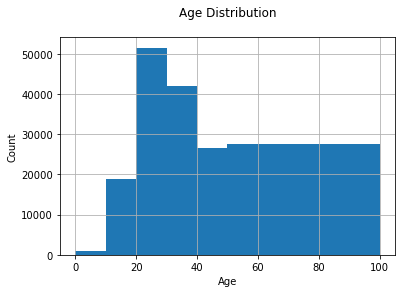

In [279]:
# checking the Age distribution
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title("Age Distribution\n")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


The most active users are in the age bracket between 20 to 30 years.

Text(0.5, 1.0, 'Outliers present in the Age column')

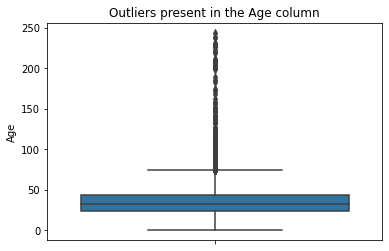

In [280]:
# checking for outliers in the age column using a boxplot
sns.boxplot(y="Age", data=users)
plt.title("Outliers present in the Age column")


Looking at the distribution plot the age is skewed to the right and has outliers. Replacing the missing age values and values less than 10 and greater than 80 with the median will be the robust approach since it's not sensitive to extreme values compared to using the mean.

In [281]:
# checking all values present in the Age column
print(sorted(list(users["Age"].unique())))


[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Text(0.5, 1.0, 'Age Distribution Plot')

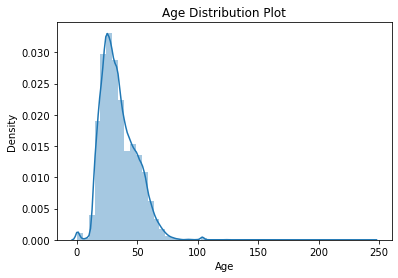

In [282]:
# plotting a distribution plot to discover the relevant age bracket
sns.distplot(users.Age)
plt.title("Age Distribution Plot")


Evidently, users with ages less than 10 and above 80 are not an appropriate target for our book recommendation system since we assume they will not be able to access a library or use the recommendation system.

In [283]:
# Select rows where the age column is greater than 10 and less than 80
users_filtered = users[(users["Age"] >= 10) & (users["Age"] <= 80)]


> find the median of the users age between 10 and 80, then replace the outliers and missing values with the median.

In [284]:
# calculating the median for the required ages
median = users_filtered["Age"].median()
median


32.0

In [285]:
# Replace the entries less than 10 or greater than 80 with the median
users.loc[(users["Age"] < 10) | (users["Age"] > 80), "Age"] = median


In [286]:
# Replace missing values in the "age" column with the median age
users["Age"] = users["Age"].fillna(median)


> convert from data type from float to integer

In [287]:
# convert the age column to int
users["Age"] = pd.to_numeric(users["Age"], downcast="integer")


In [288]:
print(sorted(list(users["Age"].unique())))


[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


In [289]:
# confirming that the missing values have been dealt with
users.isna().sum()


User-ID    0
Age        0
City       0
State      0
Country    0
dtype: int64

In [290]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int8  
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(1), int8(1), object(3)
memory usage: 8.8+ MB


### 3.4 `ratings`

In [291]:
# cleaning the ratings ISBN column using the correct_isbn function
ratings["ISBN"] = ratings["ISBN"].apply(correct_isbn)


In [292]:
# getting rid of the special characters present in the ISBN column
from string import punctuation

ratings["ISBN"] = ratings["ISBN"].apply(
    lambda x: x.translate(str.maketrans("", "", punctuation)).replace(" ", "").upper()
)

In [293]:
# ensuring the special characters have been dealt with
ratings["ISBN"] = ratings["ISBN"].apply(correct_isbn)


In [294]:
# ensuring ratings dataset has only books in the merged dataset for books and books extra
ratings_new = ratings[ratings.ISBN.isin(books_data.ISBN)]
ratings.shape, ratings_new.shape


((1149780, 3), (833962, 3))

It can be seen that many rows having book ISBN not part of the merged dataset for books and books extra got dropped off

In [295]:
# ensuring ratings dataset has only books in the users dataset
print("Shape of dataset before dropping", ratings.shape)
ratings_new = ratings_new[ratings_new["User-ID"].isin(users["User-ID"])]
print("Shape of dataset after dropping", ratings_new.shape)


Shape of dataset before dropping (1149780, 3)
Shape of dataset after dropping (833962, 3)


It is evident that no new user was there in the users dataset.

In [296]:
# segregating implicit and explicit ratings datasets
ratings_explicit = ratings_new[ratings["Book-Rating"] != 0]
ratings_implicit = ratings_new[ratings["Book-Rating"] == 0]


In [297]:
# Create column Rating average consisting the mean of the explicit ratings
ratings_explicit["Avg_Rating"] = ratings_explicit.groupby("ISBN")[
    "Book-Rating"
].transform("mean")
# Create column Total-No-Of-Users-Rated consisting the count of explicit ratings
ratings_explicit["Total_No_Of_Users_Rated"] = ratings_explicit.groupby("ISBN")[
    "Book-Rating"
].transform("count")

In [298]:
ratings_explicit.head()


,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
16,276747,0060517794,9,8.000000,30
19,276747,0671537458,9,7.176471,17
20,276747,0679776818,8,7.476190,21


In [299]:
# merging explicit ratings to the users dataset and books_data dataset
Final_Dataset = users.copy()
Final_Dataset = pd.merge(Final_Dataset, ratings_explicit, on="User-ID")
Final_Dataset = pd.merge(Final_Dataset, books_data, on="ISBN")


In [301]:
Final_Dataset.shape


(353731, 20)

In [349]:
Final_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353731 entries, 0 to 353730
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   User-ID                  353731 non-null  int64  
 1   Age                      353731 non-null  int8   
 2   City                     353731 non-null  object 
 3   State                    353731 non-null  object 
 4   Country                  353731 non-null  object 
 5   ISBN                     353731 non-null  object 
 6   Book-Rating              353731 non-null  int64  
 7   Avg_Rating               353731 non-null  float64
 8   Total_No_Of_Users_Rated  353731 non-null  int64  
 9   Book-Title               353731 non-null  object 
 10  Book-Author              353731 non-null  object 
 11  Year-Of-Publication      353731 non-null  int32  
 12  Publisher                353731 non-null  object 
 13  Image-URL-L              353730 non-null  object 
 14  auth

> Final_Dataset has:
    > * **20** columns with **353731** rows 
    > * object, integer, and float as uniques data types
    

### 3.5 Exploratory Data Analysis (EDA)

> **Exploratory Data Analysis** is an approach of analyzing data sets to summarize their main characteristics, often using data visualization methods

#### 3.5.1 Univariate Analysis

> The purpose of doing **univariate analysis** is to understand the distribution of values for a single variable.

##### 3.5.1.1 `users`


In [305]:
# Create a function that visualizes the value counts of a column
def plot_top_value_counts(dataframe, column, top_n=20):
    """
    Plots a bar chart for the value counts of the top 20 values of a DataFrame column.


    """
    value_counts = dataframe[column].value_counts()
    top_value_counts = value_counts.iloc[:top_n]
    plt.figure()
    top_value_counts.plot.bar(figsize=(10, 6))
    plt.title(f"Top {top_n} value count for {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


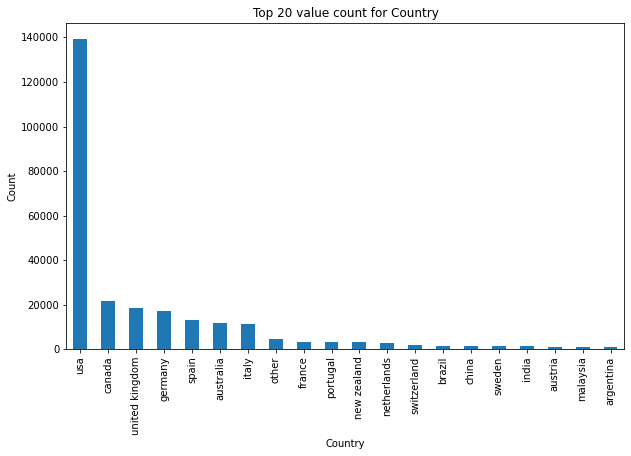

In [306]:
# plotting a countplot of cities
plot_top_value_counts(users, "Country")


> Majority of users are from the United States.

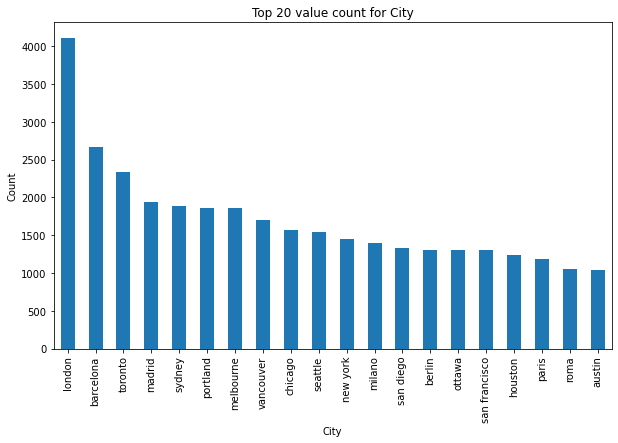

In [307]:
# plotting a countplot of states
plot_top_value_counts(users, "City")


> Most users are from london followed by barcelona.

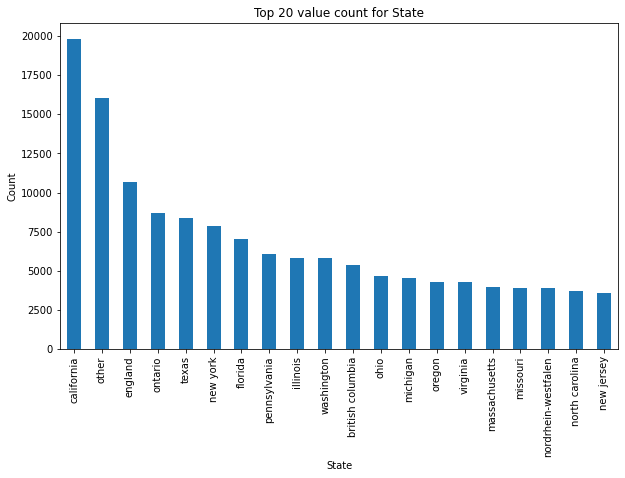

In [308]:
# plotting a countplot of Countries
plot_top_value_counts(users, "State")


>  California a state located on the west coast of the United States, is the leading state with most users.

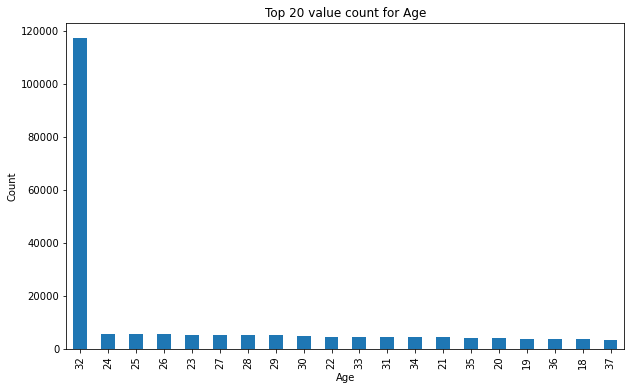

In [309]:
# plotting a countplot of users age
plot_top_value_counts(users, "Age")


> A large proportion of users are 32 years old

##### 3.5.1.2 `books`


###### 3.5.1.2.1 authors

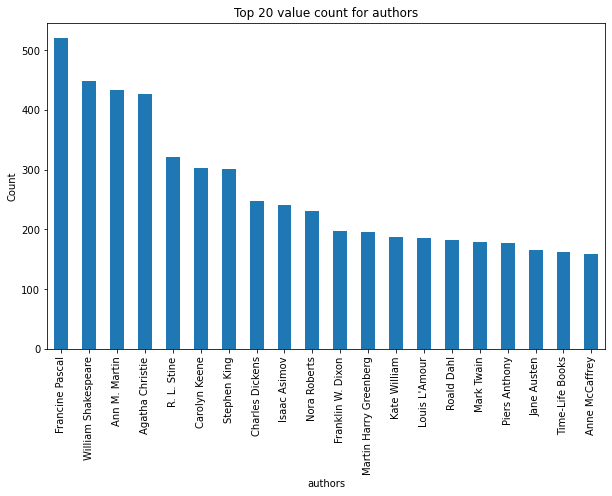

In [310]:
# plotting a countplot of Book-Author
plot_top_value_counts(books_data, "authors")


> The most recognised book authors are Francine Pascal with over 500 books, followed by William Shakespeare, Ann M. Martin and Agatha Christie.       

###### 3.5.1.2.2 Year-Of-Publication

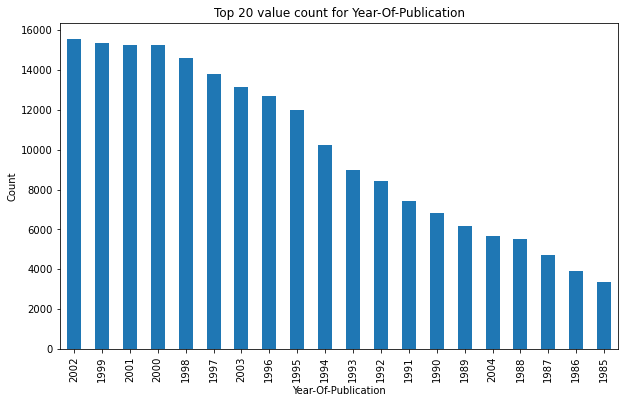

In [311]:
# plotting a countplot of Year-Of-Publication
plot_top_value_counts(books_data, "Year-Of-Publication")


> Looking at the year of publication distribution, most books were published in the early 20's and late 90's having 2002 as the leading year.

###### 3.5.1.2.3 Publisher

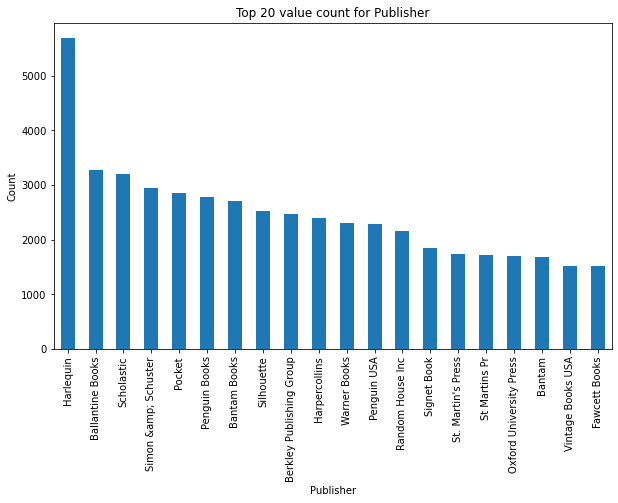

In [312]:
# plotting a countplot of book Publisher
plot_top_value_counts(books_data, "Publisher")


> Most books are published by Harlequin 

###### 3.5.1.2.4 categories

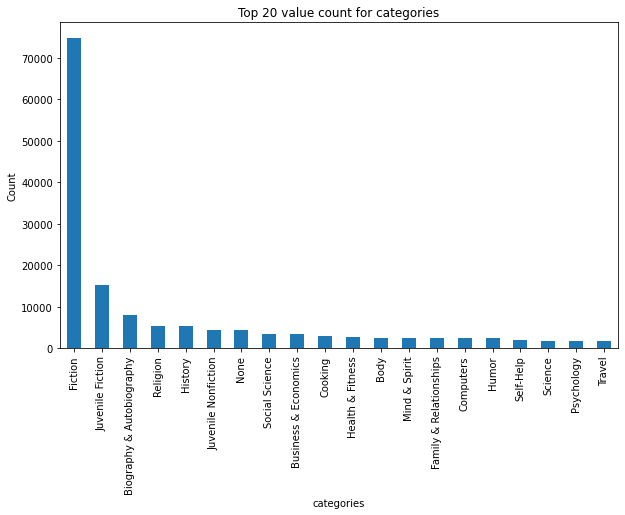

In [313]:
# plotting a countplot of book categories
plot_top_value_counts(books_data, "categories")


> Fiction is the most common category of books

###### 3.5.1.2.5 language

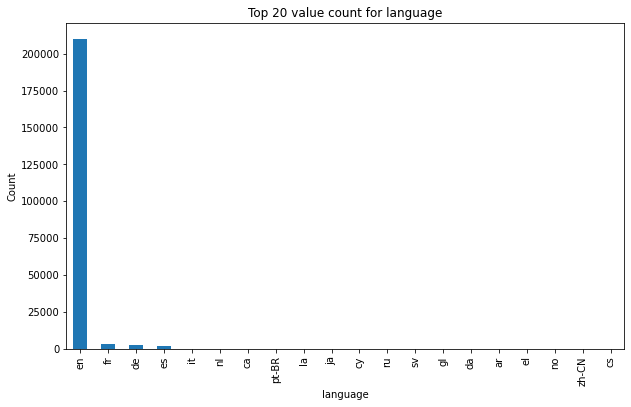

In [314]:
# plotting a countplot of book language
plot_top_value_counts(books_data, "language")


> The majority of books are written in English.

###### 3.5.1.2.6 description

In [315]:
# function for cleaning description column based on language


def clean_description(description, language):

    # Check for missing values and replace with empty string
    if pd.isnull(description):
        description = ""

    # Remove any HTML tags from the description
    description = re.sub(r"<[^>]*>", "", description)

    # Replace any non-alphabetic characters with a space
    description = re.sub(r"[^a-zA-Z]", " ", description)

    # Tokenize the description
    tokens = word_tokenize(description)

    # Remove any stop words from the description
    stop_words = set(stopwords.words(language))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    description = " ".join(tokens)

    # Remove any extra whitespace
    description = re.sub(r"\s+", " ", description).strip()

    # Return the cleaned description
    return description

In [316]:
# Create a new dataframe with only rows where language is "english"
english_books = books_data[books_data["language"] == "en"]


In [317]:
# applying the cleaning function on english books
english_books["description"] = english_books["description"].apply(
    lambda x: clean_description(x, "english")
)

In [318]:
# WordCloud function
def generate_wordcloud(
    df, column, max_words=100, width=800, height=400, min_word_length=3
):
    # Create a string from the specified column of the dataframe
    text = " ".join(description for description in df[column])

    # Generate a word cloud with the specified parameters
    wordcloud = WordCloud(
        max_words=max_words, width=width, height=height, min_word_length=min_word_length
    ).generate(text)

    # Display the word cloud
    fig = plt.figure(figsize=(14, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

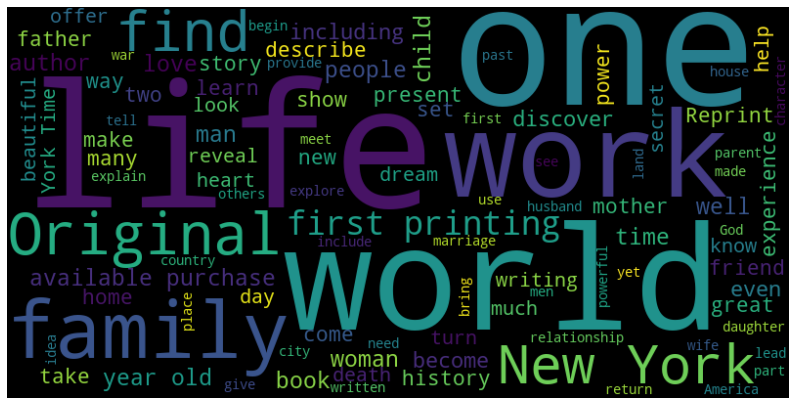

In [319]:
# wordcloud for english books
generate_wordcloud(
    english_books,
    "description",
    max_words=100,
    width=800,
    height=400,
    min_word_length=3,
)

> The majority of English books under description focus on the life, family, world, and work.

##### 3.5.1.3 `ratings`

In [320]:
# defining a function for plotting a countplot
def count_plot(column, dataset, heading):
    """Visualize the countplots of various dataframes with seaborn barplot

    Args:
        data: dataframe of various columns and their count returned from count_plot function

    Returns:
        countplot: countplot of columns and their count
    """
    plt.figure(figsize=(15, 8))
    sns.countplot(
        y=column, data=dataset, order=pd.value_counts(dataset[column]).iloc[0:15].index
    )
    plt.title(heading)

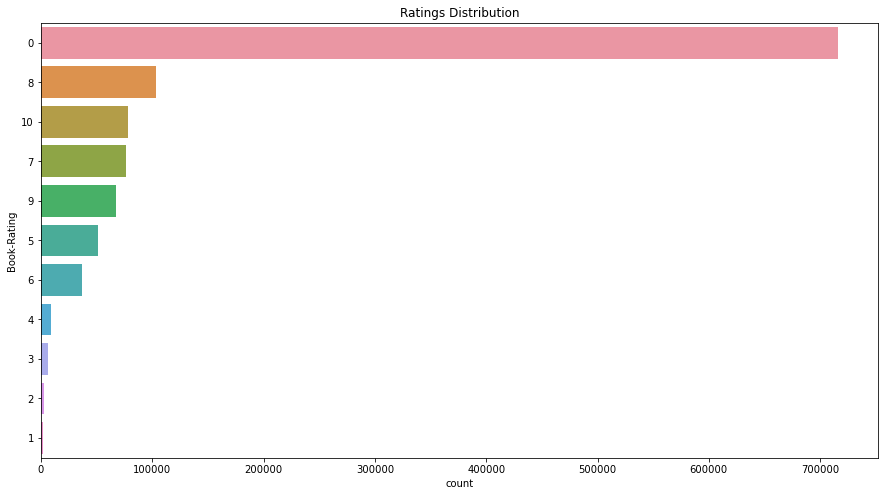

In [321]:
# checking the distribution of ratings
count_plot("Book-Rating", ratings, "Ratings Distribution")


The ratings are unevenly distributed since majority of the ratings are 0. The ratings are either explicit, expressed on a scale of 1-10 with higher values denoting higher appreciation, or implicit, expressed by 0. Hence the need to segragate implicit and explict ratings datasets

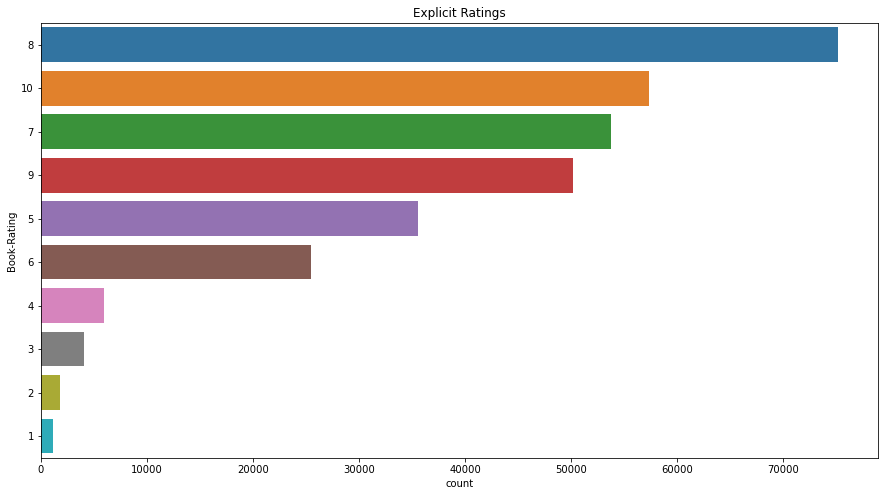

In [322]:
# plotting the explicit ratings
count_plot("Book-Rating", ratings_explicit, "Explicit Ratings")


It can be observed that higher ratings are most common amongst users and rating 8 has been rated the highest number of times.

In [323]:
# finding the top 5 books that are rated most
rating_count = pd.DataFrame(ratings_explicit.groupby("ISBN")["Book-Rating"].count())
rating_count.sort_values("Book-Rating", ascending=False).head()


,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,490
0312195516,383
059035342X,315


Majority of the books that had a high rating are mainly of category fiction and are all novels. This shows that novels of type fiction are mainly preferred by users

##### 3.5.1.4 Combined

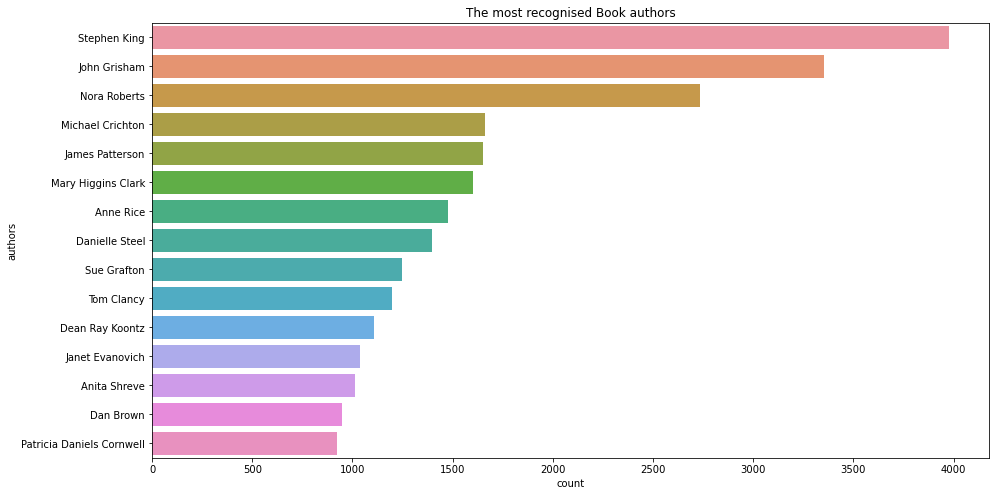

In [324]:
# plotting the most recognised book authors
count_plot("authors", Final_Dataset, "The most recognised Book authors")


>The most recognised book authors are Stephen King and John Grisham. On the other hand, Dan Brown and Patricia Dniels Cornwell are the least recognised book authors.

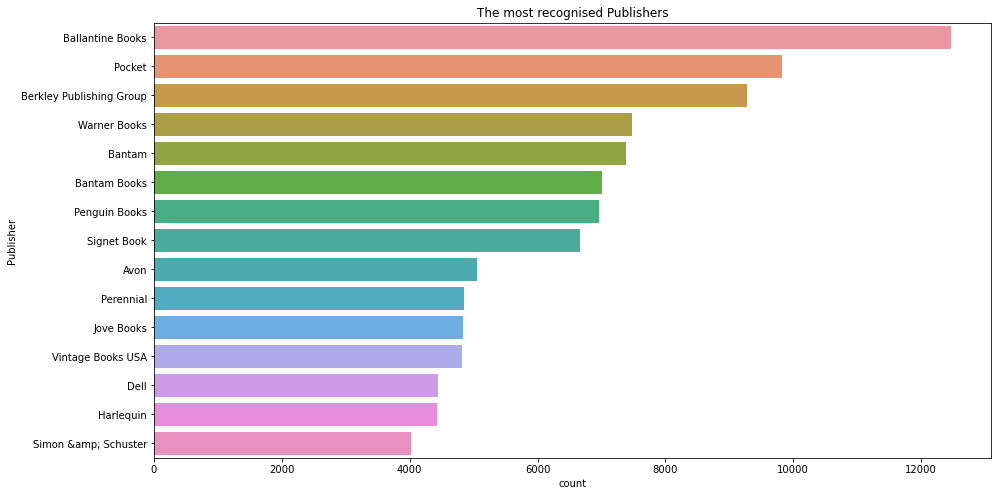

In [325]:
# plotting the most recognised publishers
count_plot("Publisher", Final_Dataset, "The most recognised Publishers")


>The most recognised publisher is Ballantine Books and Pocket while the least recognised publisher is Harlequin and Simon &amp Schuster.

#### 3.5.2 Bivariate Analysis

> The purpose of **bivariate** analysis is to understand the relationship between two variables

##### 3.5.2.1 books

###### 3.5.2.1.1 categories and language

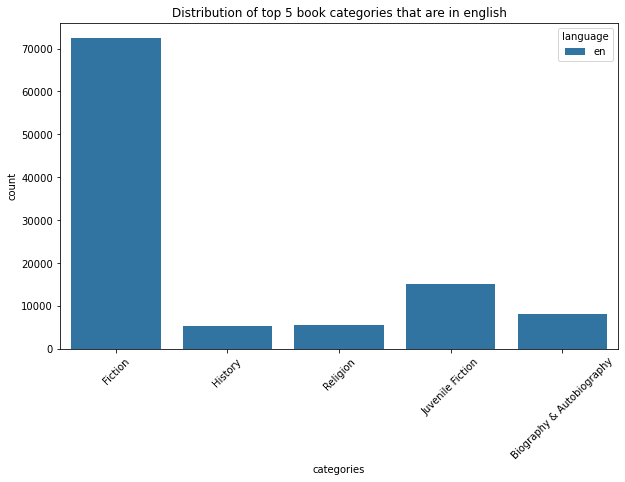

In [326]:
# Select the top 5 categories
top_5_categories = (
    books_data.groupby("categories")["categories"]
    .count()
    .sort_values(ascending=False)
    .head(5)
)
# Filter the data to only include the top 5 categories
books_data_filtered = books_data[
    books_data["categories"].isin(top_5_categories.index)
    & (books_data["language"] == "en")
]


plt.figure(figsize=(10, 6))
sns.countplot(x="categories", hue="language", data=books_data_filtered)
plt.xticks(rotation=45)
plt.title("Distribution of top 5 book categories that are in english")
plt.show()

> the leading category that is in English is Fiction

###### 3.5.2.1.2 maturity_rating and language

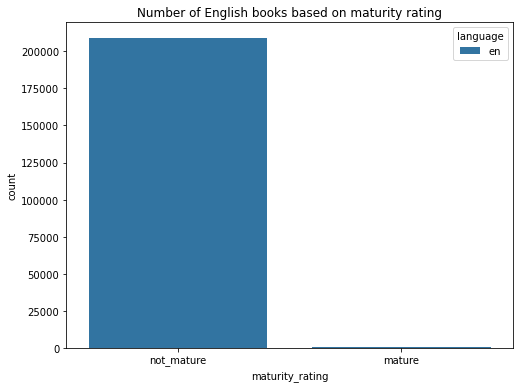

In [327]:
# create plot for
# Filter the data to only include rows where the language is 'english'
books_data_filtered = books_data[books_data["language"] == "en"]

# Create the figure with dimensions 8 inches wide and 6 inches tall
plt.figure(figsize=(8, 6))

# Create the countplot
sns.countplot(x="maturity_rating", hue="language", data=books_data_filtered)
plt.title("Number of English books based on maturity rating")
plt.show()


> Most english books are not_mature

##### 3.5.2.2 Combined

In [328]:
# function to plot bivariate analysis
def plot_bivariate(df, x, y):
    # Take the top 10 value counts for x and y
    x_top_10 = x.value_counts().head(10)
    y_top_10 = y.value_counts().head(10)

    # Create a bivariate bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=x_top_10.index, y=y_top_10.values, hue=y_top_10.index)
    plt.title("{} vs {}".format(x.name, y.name))
    plt.ylabel(y.name, fontsize=12)
    plt.xlabel(x.name, fontsize=12)
    plt.xticks(rotation="vertical")
    plt.show()


###### 3.5.2.2.1 authors & Year-Of-Publication

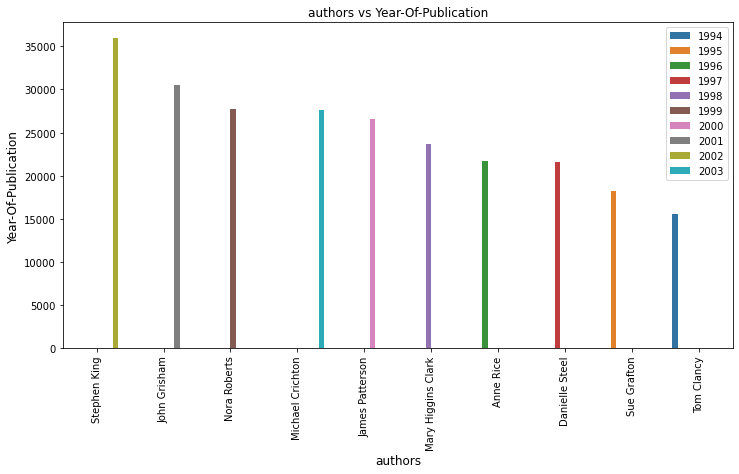

In [329]:
plot_bivariate(
    Final_Dataset, Final_Dataset["authors"], Final_Dataset["Year-Of-Publication"]
)

> Stephen King is the top most author of books published in 2002 and John Grisham in 2001.

###### 3.5.2.2.2 authors & Year-Of-Publication Publisher & Book-Rating

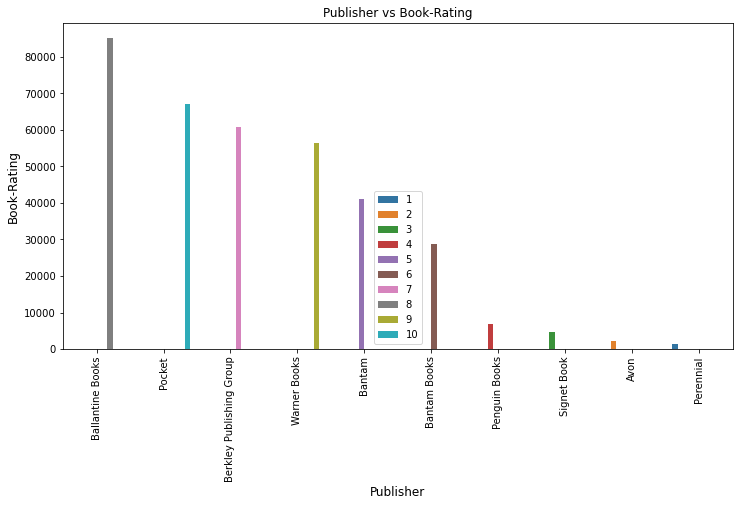

In [330]:
plot_bivariate(Final_Dataset, Final_Dataset["Publisher"], Final_Dataset["Book-Rating"])


> Most books published by Ballantine Books, have a rating of 8.

###### 3.5.2.2.3 language & categories

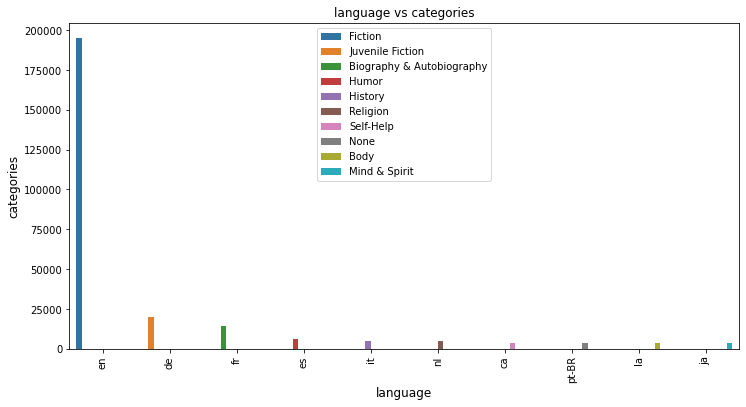

In [331]:
plot_bivariate(Final_Dataset, Final_Dataset["language"], Final_Dataset["categories"])


> English is the common language used in fiction books.

## 4. Modeling
> The goal of the Modeling phase is to build recommendation systems. We will be focusing on the following models:
>
1. Popularity Based Recommender

2. Collaborative Based Filtering:
      * Item-Based Collaborative Filtering
      * User-Based Collaborative Filtering
3. Content Based Filtering: (Where we shall be using the following columns)
      * Book-Title
      * Book-Author
      * Categories
      * Publisher
      * **Description**

### 4.1 Popularity-Based 

In [332]:
# Define a function to return the most popular books
def popular_books(df, n: int):
    """This function returns the n most popular books from the dataset.

    Args:
        df: DataFrame containing the ratings information
        n (integer): The number of books to return
    """

    # # Load DataFrame
    # books = pd.read_csv(
    #     "./data/books.csv.gzip", compression="gzip", encoding="iso-8859-1"
    # )

    # Calculate the number of ratings and the average rating for each book
    popular_books_df = (
        df.groupby("ISBN").agg({"Book-Rating": ["count", "mean"]}).reset_index()
    )
    popular_books_df.columns = ["ISBN", "NumberOfVotes", "AverageRatings"]

    # Calculate the popularity score for each book using a weighted average of the rating and number of votes
    C = popular_books_df["AverageRatings"].mean()
    m = popular_books_df["NumberOfVotes"].quantile(0.90)
    popular_books_df["Popularity"] = (
        popular_books_df["NumberOfVotes"] * popular_books_df["AverageRatings"] + m * C
    ) / (popular_books_df["NumberOfVotes"] + m)

    # Sort the books in descending order by popularity score
    popular_books_df.sort_values(by="Popularity", ascending=False, inplace=True)

    # Merge the popularity score with the books dataframe
    popular_books_df = popular_books_df.merge(books, on="ISBN", how="left")

    # Drop the duplicate book titles
    popular_books_df.drop_duplicates(subset="Book-Title", inplace=True)

    # Return the top n most popular books
    return popular_books_df.head(n)

### 4.2 Item-Based

In [333]:
def item_based(bookTitle):

    # Changing Book Title input to string
    bookTitle = str(bookTitle)

    # Classifying books with fewer than 200 ratings as rare and with more than 200 as common
    if bookTitle in Final_Dataset["Book-Title"].values:
        rating_count = pd.DataFrame(Final_Dataset["Book-Title"].value_counts())
        rare_books = rating_count[rating_count["Book-Title"] <= 200].index
        common_books = Final_Dataset[~Final_Dataset["Book-Title"].isin(rare_books)]

        # Recommending top 3 most rated books if book title entered is rare
        if bookTitle in rare_books:
            most_common = (
                pd.Series(common_books["Book-Title"].unique()).sample(3).values
            )
            print("No Recommendations for this Book ☹️ \n ")
            print("YOU MAY TRY: \n ")
            print(*most_common, sep="\n")

        # Recommending top 5 books with highest correlation to the entered Book Title
        else:
            common_books_pivot = common_books.pivot_table(
                index=["User-ID"], columns=["Book-Title"], values="Book-Rating"
            )
            title = common_books_pivot[bookTitle]
            recommendation_df = pd.DataFrame(
                common_books_pivot.corrwith(title).sort_values(ascending=False)
            ).reset_index(drop=False)

            if bookTitle in [title for title in recommendation_df["Book-Title"]]:
                recommendation_df = recommendation_df.drop(
                    recommendation_df[
                        recommendation_df["Book-Title"] == bookTitle
                    ].index[0]
                )

            less_rating = []
            for i in recommendation_df["Book-Title"]:
                if (
                    Final_Dataset[Final_Dataset["Book-Title"] == i][
                        "Book-Rating"
                    ].mean()
                    < 5
                ):
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df = recommendation_df[
                    ~recommendation_df["Book-Title"].isin(less_rating)
                ]

            recommendation_df = recommendation_df[0:5]
            recommendation_df.columns = ["Book-Title", "Correlation"]

            print("WOULD YOU LIKE to TRY THESE BOOKS?")
            for title, corr in zip(
                recommendation_df["Book-Title"], recommendation_df["Correlation"]
            ):
                print(title, corr)

    else:
        most_pop = popular_books(Final_Dataset, n=5)
        print(" COULD NOT FIND ")
        print("Consider our Most Popular Books: \n")
        print(*most_pop["Book-Title"].values, sep="\n")

In [334]:
item_based("Me Talk Pretty One Day")


WOULD YOU LIKE to TRY THESE BOOKS?
Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1) 1.0
The Chamber 0.9999999999999999
She's Come Undone (Oprah's Book Club) 0.9999999999999999
The Poisonwood Bible: A Novel 0.9999999999999999
Timeline 0.944911182523068


In [335]:
item_based("Black House")


No Recommendations for this Book ☹️ 
 
YOU MAY TRY: 
 
Girl with a Pearl Earring
The Poisonwood Bible: A Novel
Timeline


In [336]:
item_based("Barbie")


 COULD NOT FIND 
Consider our Most Popular Books: 

Harry Potter and the Chamber of Secrets Postcard Book
The Complete Monty Python's Flying Circus : All the Words, Volume 1
The Return of the King (The Lord of the Rings, Part 3)
Route 66 Postcards: Greetings from the Mother Road
William Shakespeare: The Complete Works


### 4.3 User Based

In [337]:
def users_choice(id):

    users_fav = new_df[new_df["User-ID"]==id].nlargest(5, 'Book-Rating')
    return users_fav


def user_based(new_df,id):
    if id not in new_df["User-ID"].values:
        print(" User NOT FOUND ")
    else:
        index=np.where(users_pivot.index==id)[0][0]
        similarity=cosine_similarity(users_pivot)
        similar_users=sorted(enumerate(similarity[index]),key = lambda x:x[1],reverse=True)[0:5]
        user_rec=[]
        for i in similar_users:
            data=Final_Dataset[Final_Dataset["User-ID"]==users_pivot.index[i[0]]]
            user_rec.extend(data.drop_duplicates("User-ID")["User-ID"].values) 
    return user_rec


def common(new_df, user, user_id):
    x=new_df[new_df["User-ID"]==user_id]
    user_books = x["Book-Title"].tolist()
    user_titles = set(user_books)
    
    recommend_books = []
    for i in user:
        y = new_df[(new_df["User-ID"]==i)]
        books = y[~y["Book-Title"].isin(user_titles)].sort_values(["Book-Rating"],ascending=False)[0:5]
        recommend_books.extend(books["Book-Title"].tolist())
    
    return recommend_books[0:5]

In [338]:
#Pivot Table of users who have voted >200 times (less computational demand)
new_df=Final_Dataset[Final_Dataset['User-ID'].map(Final_Dataset['User-ID'].value_counts()) > 200]
users_pivot = new_df.pivot_table(index=["User-ID"], columns=["Book-Title"], values="Book-Rating").fillna(0)

user_id=random.choice(new_df["User-ID"].values)
key_columns = ['Book-Title','Book-Author','categories']
user_choice_df=pd.DataFrame(users_choice(user_id))
user_favorite=users_choice(user_id)
n=len(user_favorite)
print(" USER: {} ".format(user_id))
print("Your Favourite Books are:\n")

for i in range(n):
    print(new_df.loc[new_df["Book-Title"]==user_choice_df["Book-Title"].tolist()[i]][key_columns].values[0])


user_based_rec=user_based(new_df,user_id)
books_for_user=common(new_df,user_based_rec,user_id)
books_for_userDF=pd.DataFrame(books_for_user,columns=["Book-Title"])    

print('\n')
print("You might also like:\n")
for i in range(5):
    print(new_df.loc[new_df["Book-Title"]==books_for_userDF["Book-Title"].tolist()[i]][key_columns].values[0])

 USER: 248718 
Your Favourite Books are:

["The Handmaid's Tale" 'Margaret Atwood'
 'British and Irish fiction (Fictional works by one author).']
['The Surveillance' 'Julian May' 'Fiction']
['The Faded Sun Trilogy' 'C. J. Cherryh' 'Fiction']
['Blade Runner' 'Philip K. Dick' 'Androids']
['The Chosen' 'Chaim Potok' 'Fiction']


You might also like:

['The Scions of Shannara (Heritage of Shannara (Paperback))'
 'Terry Brooks' 'Fiction']
['The Kagonesti (Dragonlance Lost Histories, Vol. 1)' 'Douglas Niles'
 'Fiction']
['Fifth Quarter (Daw Book Collectors)' 'Tanya Huff' 'Fiction']
['Dragonquest Achille Cover' 'Anne Mccaffrey' 'Dragons']
['MAGICIAN : MASTER' 'RAYMOND FEIST' 'Fiction']


### 4.4 Content Based

In [339]:
def content_based_recommender(book_title, n=5):
    
    book_title = str(book_title)
    
    if book_title in Final_Dataset['Book-Title'].values:
        
        rating_counts = pd.DataFrame(Final_Dataset['Book-Title'].value_counts())
        
        rare_books = rating_counts[rating_counts['Book-Title'] <= 100].index
        common_books = Final_Dataset[~Final_Dataset['Book-Title'].isin(rare_books)]
        
        common_books = common_books.drop_duplicates(subset=['Book-Title'])
        common_books.reset_index(inplace= True)
        
        common_books['index'] = [i for i in range(common_books.shape[0])]
        
        target_cols = ['Book-Title','Book-Author','Publisher','categories']
        
        common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
        
        
        cv = CountVectorizer()
        
        count_matrix = cv.fit_transform(common_books['combined_features'])
        
        cosine_sim = cosine_similarity(count_matrix)
        
        index = common_books[common_books['Book-Title'] == book_title]['index'].values[0]
        sim_books = list(enumerate(cosine_sim[index]))
        sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                  reverse=True)[1:6]
        
        books = []
        for i in range(len(sorted_sim_books)):
            books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['Book-Title'].item())

        if book_title in rare_books:
            random = pd.Series(common_books['Book-Title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
            
        else:
            print('You may also like these books')
            for i in range(len(books)):
                print(common_books.loc[common_books['Book-Title'] == books[i]][target_cols])
    else:
        most_pop = popular_books(Final_Dataset, n)
        print(" COULD NOT FIND ")
        print("Consider our Most Popular Books: \n")
        print(*most_pop["Book-Title"].values, sep="\n")

### 4.5 Hybrid Recommender (Item-Based [1] + Content Based [3] + Popularity [1])

In [340]:
def hybrid_recommender(book_title):

    # Convert the parameters to the correct data type
    book_title = str(book_title)
    
    # 1. ITEM BASED RECOMMENDATION
    # Check if the book is in the dataset
    if book_title in Final_Dataset["Book-Title"].values:

        # Get the rating counts for each book
        rating_counts = pd.DataFrame(Final_Dataset["Book-Title"].value_counts())

        # If the book has less than 100 ratings, it is considered as rare
        rare_books = rating_counts[rating_counts["Book-Title"] <= 180].index

        # If the book is not rare, then it is considered as common
        common_books = Final_Dataset[~Final_Dataset["Book-Title"].isin(rare_books)]

        # If the book is rare, then recommend n random books
        if book_title in rare_books:

            random = common_books.sample(5)
            
            # --- For the notebook ---
            # Print the titles of the random books
            print("There are no recommendations for this book")
            print("Try: \n")

            for i in range(n):
                # Print the book title
                print(f'{i + 1}. {random["Book-Title"].iloc[i]}')
                
            # --- For the web app ---
            # Return the random books as a dataframe
            return random

        # If the book is common, then recommend n books based on the correlation
        else:

            # Create user-book matrix that contains the rating for each book by each user
            user_book_df = common_books.pivot_table(
                index=["User-ID"], columns=["Book-Title"], values="Book-Rating"
            )

            # Store the user ratings for the book in a series
            book = user_book_df[book_title]

            # Create a dataframe that stores the correlation between the book and other books in order
            recom_data = pd.DataFrame(
                user_book_df.corrwith(book).sort_values(ascending=False)
            ).reset_index(drop=False)

            # Drop the book title from the 'recom_data' dataframe
            if book_title in [book for book in recom_data["Book-Title"]]:
                recom_data = recom_data.drop(
                    recom_data[recom_data["Book-Title"] == book_title].index[0]
                )

            # Create an empty list called 'low_rating' 
            low_rating = []
            
            # Loop through the books in the 'recom_data' dataframe
            for i in recom_data["Book-Title"]:
                
                # If the mean rating of the book is less than 5, append the book to the low rating list
                if (
                    Final_Dataset[Final_Dataset["Book-Title"] == i][
                        "Book-Rating"
                    ].mean()
                    < 5
                ):
                    low_rating.append(i)
            
            # Check if the shape of the non-low rating books is greater than n
            if recom_data.shape[0] - len(low_rating) > n:
                
                # Drop the books with low rating from the 'recom_data' dataframe
                recom_data = recom_data[~recom_data["Book-Title"].isin(low_rating)]

            # Store the book with the highest correlation in a list
            recom_data = recom_data[0:1]
            recom_data.columns = ["Book-Title", "corr"]
            recommended_books = []
            for i in recom_data["Book-Title"]:
                recommended_books.append(i)

            # Remove the book with the highest correlation from the book ratings dataframe. This will be used in the content-based recommendation
            df_new = Final_Dataset[~Final_Dataset["Book-Title"].isin(recommended_books)]

            # 2. CONTENT-BASED (Title, Author, Publisher, Category)

            # Get the rating counts for each book in the new dataframe
            rating_counts = pd.DataFrame(df_new["Book-Title"].value_counts())

            # If the book has less than 100 ratings, it is considered as rare, otherwise it is common
            rare_books = rating_counts[rating_counts["Book-Title"] <= 100].index
            common_books = df_new[~df_new["Book-Title"].isin(rare_books)]
            
            # Drop the duplicates in the 'common_books' dataframe
            common_books = common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            
            # Create a column called index
            common_books["index"] = [i for i in range(common_books.shape[0])]
            
            # Create a column called combined_features and combine the title, author, publisher and category of the book 
            target_cols = ["Book-Title", "Book-Author", "Publisher", "categories"]
            common_books["combined_features"] = [
                " ".join(
                    common_books[target_cols]
                    .iloc[
                        i,
                    ]
                    .values
                )
                for i in range(common_books[target_cols].shape[0])
            ]
            
            # Instantiate the CountVectorizer
            cv = CountVectorizer()
            
            # Fit and transform the 'combined_features' column
            count_matrix = cv.fit_transform(common_books["combined_features"])
            
            # Calculate the cosine similarity between the books
            cosine_sim = cosine_similarity(count_matrix)
            
            # Get the index of the book
            index = common_books[common_books["Book-Title"] == book_title][
                "index"
            ].values[0]
            
            # Store the cosine similarity scores in a list
            sim_books = list(enumerate(cosine_sim[index]))
            
            # Sort the books based on the cosine similarity scores
            sorted_sim_books = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:2]

            # Create a list to store the recommended books
            books = []
            
            # Loop through the sorted books and append the book title to the list
            for i in range(len(sorted_sim_books)):
                books.append(
                    common_books[common_books["index"] == sorted_sim_books[i][0]][
                        "Book-Title"
                    ].item()
                )

            # Append the book to to the recommended books list
            for i in books:
                recommended_books.append(i)

            # Remove the book from the ratings dataframe
            df_new = df_new[~df_new["Book-Title"].isin(recommended_books)]

            #3. CONTENT-BASED (Description)
            # Get the rating counts for each book in the new dataframe
            rating_counts = pd.DataFrame(df_new["Book-Title"].value_counts())
            
            # If the book has less than 100 ratings, it is considered as rare, otherwise it is common
            rare_books = rating_counts[rating_counts["Book-Title"] <= 100].index
            common_books = df_new[~df_new["Book-Title"].isin(rare_books)]

            # Drop the duplicates in the 'common_books' dataframe
            common_books = common_books.drop_duplicates(subset=["Book-Title"])
            common_books.reset_index(inplace=True)
            
            # Create a column for the index
            common_books["index"] = [i for i in range(common_books.shape[0])]
            
            # Preprocess the description column
            summary_filtered = []
            
            for i in common_books["description"]:
                
                # Convert the description to lowercase
                i = re.sub("[^a-zA-Z]", " ", i).lower()
                
                # Tokenize the description
                i = nltk.word_tokenize(i)
                
                # Remove the stopwords
                i = [word for word in i if not word in set(stopwords.words("english"))]
                
                # Join the tokens
                i = " ".join(i)
                
                # Append the description to the list
                summary_filtered.append(i)

            # Replace the description column with the preprocessed description
            common_books["description"] = summary_filtered
            
            # Instantiate the CountVectorizer
            cv2 = CountVectorizer()
            
            # Fit and transform the 'description' column
            count_matrix = cv2.fit_transform(common_books["description"])
            
            # Calculate the cosine similarity between the book descriptions
            cosine_sim = cosine_similarity(count_matrix)
            
            # Find the index of the book
            index = common_books[common_books["Book-Title"] == book_title][
                "index"
            ].values[0]
            
            # Store the cosine similarity scores in a list
            sim_books = list(enumerate(cosine_sim[index]))
            
            # Sort the books based on the cosine similarity scores. Select 3 books
            sorted_sim_books2 = sorted(sim_books, key=lambda x: x[1], reverse=True)[1:4]
  
            # Create a list to store the recommended books
            sorted_sim_books = sorted_sim_books2[:2]
            summary_books = []
            for i in range(len(sorted_sim_books)):
                summary_books.append(
                    common_books[common_books["index"] == sorted_sim_books[i][0]][
                        "Book-Title"
                    ].item()
                )

            for i in summary_books:
                recommended_books.append(i)

            # Remove the book from the ratings dataframe 
            df_new = df_new[~df_new["Book-Title"].isin(recommended_books)]

            # 4. TOP RATED OF CATEGORY
            # Get the category of the book
            category = common_books[common_books["Book-Title"] == book_title][
                "categories"
            ].values[0]
            
            # Get the top rated books of the category
            top_rated = (
                common_books[common_books["categories"] == category]
                .groupby("Book-Title")
                .agg({"Book-Rating": "mean"})
                .reset_index()
            )

            # If there is only one book in the category, append it to the recommended books list
            if top_rated.shape[0] == 1:
                recommended_books.append(
                    common_books[common_books["index"] == sorted_sim_books2[2][0]][
                        "Book-Title"
                    ].item()
                )
            # If there are more than one book in the category, sort the books based on the rating and append the top rated book to the recommended books list
            else:
                top_rated.drop(
                    top_rated[top_rated["Book-Title"] == book_title].index[0],
                    inplace=True,
                )
                
                top_rated = (
                    top_rated.sort_values("Book-Rating", ascending=False)
                    .iloc[:1]["Book-Title"]
                    .values[0]
                )
                
                recommended_books.append(top_rated)
            target_cols = ["Book-Title", "Book-Author", "Publisher", "categories"]
            
            
            return recommended_books

    else:
        print("Cant find book in dataset, please check spelling")

In [341]:
hybrid_recommender("The Brethren")

['1st to Die: A Novel',
 'The Rainmaker',
 'The Beach House',
 'The Chamber',
 'A Is for Alibi (Kinsey Millhone Mysteries (Paperback))']

## 5. Evaluation

> The goal of the evaluation phase is to evaluate the final model(s) and determine whether the results are useful. It has three main tasks:  
>  * Evaluate Results
>  * Review Process
>  * Determine Next Steps

The metric used to evaluate the performance of the recommender systems is **Mean Absolute Error (MAE)**, this is because it is not sensitive to outliers and is easy to interpret. MAE is the average of the absolute differences between the predicted and actual values. The lower the MAE, the better the model.

#### Model Perfomance
* Precision: The proportion of relevant items among the recommended items.
* Recall: The proportion of relevant items that are recommended.
* Coverage: The proportion of users that receive a recommendation.
* Diversity: The distinctiveness of the recommended items.
* Novelty: The degree to which the recommended items are novel and unexpected.
* User Satisfaction: The extent to which users are pleased with the recommendations.
* A/B Testing Results: The results of performance testing between different models.
* Click-Through Rate: The percentage of users who act on the recommendations.
* Conversion Rate: The percentage of users who complete a desired action after acting on the recommendations.
* Time To Action: The amount of time between when a user receives a recommendation and when they act on it.

In [342]:
# Define a function to calculate the mean absolute error (MAE)
def model_MAE(model_name, book_title):
    recommended_books = model_name(book_title)
    recommended_books_ratings = []
    for i in recommended_books:
        if i in Final_Dataset["Book-Title"].values:
            x = Final_Dataset[Final_Dataset["Book-Title"] == i]["Book-Rating"].mean()
            recommended_books_ratings.append(x)

            true_books_ratings = Final_Dataset[
                Final_Dataset["Book-Title"] == book_title
            ]["Book-Rating"].mean()
            error = abs(true_books_ratings - np.mean(recommended_books_ratings))
            MAE = error / true_books_ratings

            return MAE